# Solveur CVRPTW - Capacitated Vehicle Routing Problem with Time Windows
## Optimisation de tournées avec contraintes de capacité et fenêtres temporelles

**Date:** Novembre 2025

---

## Caractéristiques
- ✅ **CVRPTW complet** : Capacité + Fenêtres temporelles
- ✅ **Flotte homogène** : k camions identiques (capacité fixe)
- ✅ **Dépôt unique** : Point de départ/arrivée commun
- ✅ **Temps constants** : Distances euclidiennes standards
- ✅ **Lecture automatique** : Toutes les instances du dossier data/

## Contraintes
1. **Capacité véhicule** : Somme des demandes ≤ capacité max
2. **Fenêtres temporelles** : Arrivée dans [ready_time, due_time]
3. **Temps de service** : Respect du temps de service par client

## Méthodes
1. **Clarke & Wright** : Solution initiale rapide et faisable
2. **ALNS** : Adaptive Large Neighborhood Search
   - Destruction: Random, Worst, Shaw Removal
   - Réparation: Greedy, Regret-2 Insertion
   - Acceptation: Simulated Annealing

## Objectif
- Solutions **faisables** respectant toutes les contraintes
- Gap **raisonnable** (< 10%) par rapport aux optimaux connus
- Comparaison avec benchmarks CVRPTW de référence (Solomon, etc.)

---
## 1. IMPORTS & CONFIGURATION

### Imports et Configuration

Bibliothèques nécessaires pour le solveur VRPTW simplifié :
- **numpy** : Calculs numériques
- **pandas** : Gestion de données  
- **matplotlib** : Visualisations
- **dataclasses** : Structures de données simples
- **random/math** : Algorithmes d'optimisation
- **time** : Mesure de performances

Configuration :
- Seed fixe pour reproductibilité
- Chemin vers dossier data/ avec toutes les instances

# Explication de la cellule d'import et configuration

Dans cette cellule, j’ai chargé toutes les bibliothèques nécessaires à mon projet, à la fois pour la manipulation des données, les calculs numériques et la visualisation. J’ai également configuré les paramètres pour assurer la reproductibilité des résultats avec des graines fixes pour le générateur aléatoire. Enfin, j’ai défini un style graphique pour que les figures soient cohérentes et lisibles. Cette étape prépare l’environnement pour toutes les étapes suivantes du projet.

### Détails point par point :
- **Modules Python standard :** `os`, `re`, `time`, `math`, `random` pour manipulations diverses et calculs.
- **Gestion des copies :** `deepcopy` pour copier des objets complexes sans lien avec l’original.
- **Annotations de type :** `List`, `Tuple`, `Dict`, etc., pour plus de clarté.
- **Dataclasses :** simplifie la création de classes pour clients, véhicules, solutions.
- **Bibliothèques scientifiques :** `numpy`, `pandas` pour manipulations de données.
- **Visualisation :** `matplotlib.pyplot` et style `seaborn` si disponible.
- **Dictionnaires avec valeurs par défaut :** `defaultdict` pour regrouper ou compter facilement.
- **Reproductibilité :** `random.seed(42)` et `np.random.seed(42)` pour des résultats constants.
- **Configuration graphique :** taille des figures `(12,6)` et style graphique pour lisibilité.


In [22]:
import os
import re
import time
import math
import random
from copy import deepcopy
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
random.seed(42)
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports loaded successfully")

Imports loaded successfully


---
## 2. DATA LOADING (VRPLIB Format)

### Test du Chargement des Données

Maintenant que j'ai mes fonctions de parsing, je teste le chargement d'une instance réelle (C101 de Solomon).

C'est important de vérifier que :
- Le fichier se charge correctement
- Les données sont bien parsées (clients, dépôt, fenêtres temporelles)
- Les structures sont accessibles pour la suite du projet

# Explication des fonctions de parsing et de chargement d’instances

Cette cellule contient toutes les fonctions nécessaires pour **charger et transformer les instances CVRP et CVRPTW** en structures de données exploitables par mes algorithmes.

### Détail par fonction :

1. **`parse_solomon_instance(filepath)`**
   - Lit les fichiers Solomon (.txt) pour le CVRPTW.
   - Récupère le nombre de véhicules, leur capacité et toutes les données des clients (coordonnées, demande, fenêtres temporelles et temps de service).
   - Retourne un dictionnaire avec l’instance complète.

2. **`parse_vrp_instance(filepath)`**
   - Lit les fichiers TSPLIB (.vrp) pour le CVRP.
   - Récupère les coordonnées, les demandes et la capacité des véhicules.
   - Crée des fenêtres temporelles larges pour adapter au CVRPTW si nécessaire.
   - Estime le nombre minimal de véhicules nécessaires.

3. **`load_instance(filename)`**
   - Détecte automatiquement le type d’instance (.txt ou .vrp) et appelle la fonction de parsing correspondante.
   - Cherche les fichiers dans le dossier `DATA_PATH` et ses sous-dossiers.
   - Retourne un dictionnaire complet prêt à être utilisé dans l’algorithme.

4. **`load_solution(filename)`**
   - Charge le coût optimal depuis un fichier `.sol` si disponible.
   - Supporte différents formats de fichier solution.
   - Renvoie `None` si aucun fichier solution n’est trouvé.

### Points importants :
- `DATA_PATH` définit le chemin local vers les instances.
- Réindexation des clients à partir de 0 pour compatibilité Python.
- Gestion automatique des formats CVRP et CVRPTW.
- Préparation essentielle pour l’utilisation dans les algorithmes de recherche et de métaheuristiques.


In [23]:
# Chemin vers les instances locales
DATA_PATH = r"c:\Users\THINKPAD\Downloads\CVRPTWW\data"

def parse_solomon_instance(filepath: str) -> Dict:
    """
    Parse une instance au format Solomon (.txt)
    Format: C101.txt, R101.txt, RC101.txt
    """
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    
    instance = {
        'name': os.path.basename(filepath),
        'type': 'CVRPTW'
    }
    
    # Trouver la ligne avec NUMBER CAPACITY
    vehicle_line_idx = None
    customer_line_idx = None
    
    for i, line in enumerate(lines):
        if 'NUMBER' in line and 'CAPACITY' in line:
            vehicle_line_idx = i + 1  # Ligne suivante contient les valeurs
        elif 'CUST NO.' in line or 'CUSTOMER' in line:
            customer_line_idx = i + 1  # Les données clients commencent après
    
    # Parser véhicules
    if vehicle_line_idx:
        vehicle_info = lines[vehicle_line_idx].split()
        instance['num_vehicles'] = int(vehicle_info[0])
        instance['vehicle_capacity'] = int(vehicle_info[1])
    else:
        # Valeurs par défaut
        instance['num_vehicles'] = 25
        instance['vehicle_capacity'] = 200
    
    # Parser les clients
    customers = []
    if customer_line_idx:
        for line in lines[customer_line_idx:]:
            if not line.strip():  # Ignorer lignes vides
                continue
            
            parts = line.split()
            if len(parts) < 7:
                continue
            
            try:
                customer = {
                    'id': int(parts[0]),
                    'x': float(parts[1]),
                    'y': float(parts[2]),
                    'demand': int(parts[3]),
                    'ready_time': int(parts[4]),
                    'due_time': int(parts[5]),
                    'service_time': int(parts[6])
                }
                customers.append(customer)
            except ValueError:
                # Ignorer les lignes qui ne sont pas des données
                continue
    
    instance['customers'] = customers
    instance['num_customers'] = len(customers) - 1  # Sans le dépôt
    
    return instance


def parse_vrp_instance(filepath: str) -> Dict:
    """
    Parse une instance au format TSPLIB (.vrp)
    Format: A-n32-k5.vrp, X-n101-k25.vrp
    """
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    
    instance = {
        'name': os.path.basename(filepath),
        'type': 'CVRP'
    }
    
    coords = {}
    demands = {}
    section = None
    
    for line in lines:
        if 'CAPACITY' in line:
            instance['vehicle_capacity'] = int(line.split(':')[1].strip())
        elif 'NODE_COORD_SECTION' in line:
            section = 'coords'
        elif 'DEMAND_SECTION' in line:
            section = 'demands'
        elif 'DEPOT_SECTION' in line:
            section = 'depot'
        elif 'EOF' in line:
            break
        elif section == 'coords':
            parts = line.split()
            if len(parts) == 3:
                coords[int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == 'demands':
            parts = line.split()
            if len(parts) == 2:
                demands[int(parts[0])] = int(parts[1])
    
    # Créer les clients avec fenêtres temporelles larges (pas de contrainte temporelle stricte)
    max_time = 1000
    customers = []
    for cid in sorted(coords.keys()):
        customer = {
            'id': cid - 1,  # Réindexer à partir de 0
            'x': coords[cid][0],
            'y': coords[cid][1],
            'demand': demands.get(cid, 0),
            'ready_time': 0,
            'due_time': max_time,
            'service_time': 10
        }
        customers.append(customer)
    
    instance['customers'] = customers
    instance['num_customers'] = len(customers) - 1
    
    # Estimer le nombre de véhicules nécessaires
    total_demand = sum(c['demand'] for c in customers if c['id'] > 0)
    instance['num_vehicles'] = max(5, (total_demand // instance['vehicle_capacity']) + 2)
    
    return instance


def load_instance(filename: str) -> Dict:
    """
    Charge une instance depuis le dossier data/
    Cherche d'abord à la racine, puis dans les sous-dossiers
    """
    # Chercher d'abord à la racine de data/
    filepath = os.path.join(DATA_PATH, filename)
    
    if os.path.exists(filepath):
        if filepath.endswith('.txt'):
            return parse_solomon_instance(filepath)
        elif filepath.endswith('.vrp'):
            return parse_vrp_instance(filepath)
    
    # Chercher dans les sous-dossiers
    for root, dirs, files in os.walk(DATA_PATH):
        if filename in files:
            filepath = os.path.join(root, filename)
            if filepath.endswith('.txt'):
                return parse_solomon_instance(filepath)
            elif filepath.endswith('.vrp'):
                return parse_vrp_instance(filepath)
    
    raise FileNotFoundError(f"Instance non trouvée: {filename} dans {DATA_PATH}")


def load_solution(filename: str) -> Optional[float]:
    """
    Charge le coût optimal depuis un fichier .sol
    Cherche dans data/ et ses sous-dossiers
    """
    # Chercher d'abord à la racine
    filepath = os.path.join(DATA_PATH, filename)
    
    if not os.path.exists(filepath):
        # Chercher dans les sous-dossiers
        found = False
        for root, dirs, files in os.walk(DATA_PATH):
            if filename in files:
                filepath = os.path.join(root, filename)
                found = True
                break
        
        if not found:
            print(f"Warning: Solution file not found: {filename}")
            return None
    
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Chercher le coût (différents formats possibles)
    cost_match = re.search(r'Cost\s+(\d+\.?\d*)', content, re.IGNORECASE)
    if cost_match:
        return float(cost_match.group(1))
    
    cost_match = re.search(r'(\d+\.?\d*)\s*$', content.strip())
    if cost_match:
        return float(cost_match.group(1))
    
    return None


print("Data parsing functions loaded")


Data parsing functions loaded


### Liste Automatique des Instances Disponibles

Cette cellule scanne automatiquement le dossier `data/` et liste **toutes** les instances trouvées :
- **Solomon VRPTW** : C101, R101, RC101, etc.
- **CVRP Classiques** : A-n32-k5, P-n16-k8, etc.  
- **X-Series** : Grandes instances (100 à 1000+ clients)

✅ **Avantage** : Détection automatique sans configuration manuelle

In [24]:
# ============================================================================
# LISTE DES INSTANCES DISPONIBLES
# ============================================================================

def list_available_instances(data_path: str):
    """Liste toutes les instances .txt et .vrp disponibles"""
    
    instances = {
        'Solomon (CVRPTW)': [],
        'CVRP Classic': [],
        'X-Series (100-200)': [],
        'X-Series (200-500)': [],
        'X-Series (500-1000+)': []
    }
    
    for root, dirs, files in os.walk(data_path):
        for filename in sorted(files):
            if filename.endswith('.txt') or filename.endswith('.vrp'):
                # Extraire le nombre de clients
                match = re.search(r'n(\d+)', filename, re.IGNORECASE)
                num_clients = int(match.group(1)) if match else 0
                
                # Catégoriser
                if filename.startswith(('C', 'R', 'RC')) and filename.endswith('.txt'):
                    instances['Solomon (CVRPTW)'].append(filename)
                elif filename.startswith('X-n') and filename.endswith('.vrp'):
                    if num_clients <= 200:
                        instances['X-Series (100-200)'].append(filename)
                    elif num_clients <= 500:
                        instances['X-Series (200-500)'].append(filename)
                    else:
                        instances['X-Series (500-1000+)'].append(filename)
                else:
                    instances['CVRP Classic'].append(filename)
    
    return instances

# Vérifier que DATA_PATH existe
if not os.path.exists(DATA_PATH):
    print(f"⚠️ ERREUR: Le dossier {DATA_PATH} n'existe pas!")
    print(f"Veuillez vérifier le chemin dans DATA_PATH")
else:
    # Lister les instances
    print("=" * 80)
    print("INSTANCES DISPONIBLES")
    print("=" * 80)
    
    available = list_available_instances(DATA_PATH)
    
    for category, files in available.items():
        if files:
            print(f"\n{category} ({len(files)} instances):")
            print("-" * 80)
            
            # Afficher en colonnes pour gagner de la place
            if len(files) > 10:
                # Afficher seulement quelques exemples + total
                print(f"  {', '.join(files[:5])}")
                print(f"  ... et {len(files) - 5} autres")
            else:
                for f in files:
                    print(f"  - {f}")
    
    print("\n" + "=" * 80)
    print(f"TOTAL: {sum(len(f) for f in available.values())} instances disponibles")
    print("=" * 80)

INSTANCES DISPONIBLES

Solomon (CVRPTW) (60 instances):
--------------------------------------------------------------------------------
  C101.txt, C1_2_1.txt, C101.txt, C1_2_1.txt, C101.txt
  ... et 55 autres

CVRP Classic (35 instances):
--------------------------------------------------------------------------------
  A-n32-k5.vrp, B-n31-k5.vrp, CMT6.vrp, E-n13-k4.vrp, F-n72-k4.vrp
  ... et 30 autres

X-Series (100-200) (24 instances):
--------------------------------------------------------------------------------
  X-n101-k25.vrp, X-n101-k25.vrp, X-n101-k25.vrp, X-n106-k14.vrp, X-n110-k13.vrp
  ... et 19 autres

X-Series (200-500) (46 instances):
--------------------------------------------------------------------------------
  X-n204-k19.vrp, X-n209-k16.vrp, X-n214-k11.vrp, X-n219-k73.vrp, X-n223-k34.vrp
  ... et 41 autres

X-Series (500-1000+) (32 instances):
--------------------------------------------------------------------------------
  X-n1001-k43.vrp, X-n502-k39.vrp, X-n5

In [25]:
# ============================================================================
# CONFIGURATION: Sélection de l'instance à utiliser
# ============================================================================

# Choix de l'instance (modifier cette ligne pour changer d'instance)
# 
# Exemples d'instances disponibles:
# 
# Solomon (100 clients):
#   - C101.txt, C201.txt (clients groupés)
#   - R101.txt, R201.txt (clients aléatoires)
#   - RC101.txt, RC201.txt (mixte)
# 
# X-Series petites (100-200 clients):
#   - X-n101-k25.vrp (101 clients, 25 véhicules)
#   - X-n153-k22.vrp (153 clients, 22 véhicules)
#   - X-n200-k36.vrp (200 clients, 36 véhicules)
# 
# X-Series moyennes (200-500 clients):
#   - X-n298-k31.vrp (298 clients, 31 véhicules)
#   - X-n393-k38.vrp (393 clients, 38 véhicules)
# 
# X-Series grandes (500-1000+ clients):
#   - X-n524-k153.vrp (524 clients, 153 véhicules)
#   - X-n1001-k43.vrp (1001 clients, 43 véhicules) ⚠️ TRÈS GRANDE
# 
# CVRP Classic:
#   - A-n32-k5.vrp, P-n16-k8.vrp, etc.

SELECTED_INSTANCE = 'C1_2_1.txt'  # ← Modifier ici

# Chargement de l'instance sélectionnée (données brutes)
print(f"✅ Instance sélectionnée : {SELECTED_INSTANCE}")
print(f"   (L'instance sera chargée après la définition des classes)")

# Chargement de la solution optimale si disponible
sol_name = SELECTED_INSTANCE.replace('.txt', '.sol').replace('.vrp', '.sol')
optimal_cost = load_solution(sol_name)

if optimal_cost:
    print(f"   Coût optimal connu: {optimal_cost:.2f}")
else:
    print(f"   Pas de solution optimale disponible")

✅ Instance sélectionnée : C1_2_1.txt
   (L'instance sera chargée après la définition des classes)
   Coût optimal connu: 2698.60


### Liste des Instances Disponibles

Avant de sélectionner une instance, voici toutes les instances disponibles dans mon dossier data.

Je peux voir :
- Les instances Solomon (100 clients) : C101, R101, RC101, etc.
- Les instances CVRP classiques : A-n32-k5, P-n16-k8, etc.
- Les instances X de grande taille (100 à 1000+ clients) : X-n101-k25, X-n1001-k43, etc.

Cette liste m'aide à choisir l'instance appropriée selon la taille du problème que je veux tester.

---
## 3. BASE CLASSES

### Classe Customer

Je commence par définir la classe Customer qui représente un client dans mon problème CVRPTW.

Chaque client possède :
- Un identifiant unique
- Des coordonnées (x, y) pour calculer les distances
- Une demande (quantité à livrer)
- Une fenêtre temporelle [ready_time, due_date]
- Un temps de service

Ces attributs sont essentiels pour vérifier les contraintes de capacité et de temps.

# Classes de base pour le VRP

Cette cellule définit les **objets principaux** qui servent à représenter les données de mon projet VRP/CVRPTW de manière structurée.

### 1. Customer
- Représente un client avec ses caractéristiques :
  - `id`, coordonnées (`x`, `y`)
  - Demande (`demand`)
  - Fenêtres temporelles (`ready_time`, `due_time`)
  - Temps de service (`service_time`)
- Utilise `@dataclass` pour simplifier la création et la gestion des objets.

### 2. Vehicle
- Représente un véhicule de livraison :
  - `id`, capacité (`capacity`)
  - `cost_per_km` pour prendre en compte la flotte hétérogène si nécessaire.

### 3. VRPInstance
- Représente une instance complète du problème VRP :
  - Crée les objets `Customer` et `Vehicle` à partir des données chargées.
  - Identifie le dépôt (`depot = customers[0]`).
  - Construit une **matrice des distances euclidiennes** pour tous les clients.
  - Méthode `distance(i, j)` pour accéder rapidement à la distance entre deux clients.

### Points importants
- La matrice des distances est symétrique et pré-calculée pour optimiser les performances.
- La structure orientée objet rend le code plus modulable et facile à utiliser avec les métaheuristiques (Clarke-Wright, ALNS, VND, etc.).


In [26]:
@dataclass
class Customer:
    """Représente un client avec ses caractéristiques"""
    id: int
    x: float
    y: float
    demand: int
    ready_time: int
    due_time: int
    service_time: int


@dataclass
class Vehicle:
    """Représente un véhicule avec sa capacité"""
    id: int
    capacity: int
    cost_per_km: float = 1.0  # Pour flotte hétérogène


class VRPInstance:
    """Instance complète du problème VRP"""
    
    def __init__(self, data: Dict):
        self.name = data['name']
        self.type = data['type']
        self.num_customers = data['num_customers']
        self.vehicle_capacity = data['vehicle_capacity']
        self.num_vehicles = data['num_vehicles']
        
        # Créer les objets Customer
        self.customers = [
            Customer(**c) for c in data['customers']
        ]
        
        self.depot = self.customers[0]
        
        # Créer les véhicules
        self.vehicles = [
            Vehicle(id=v, capacity=self.vehicle_capacity)
            for v in range(self.num_vehicles)
        ]
        
        # Matrice des distances
        self.distance_matrix = self._build_distance_matrix()
        
    def _build_distance_matrix(self) -> np.ndarray:
        """Construit la matrice des distances euclidiennes"""
        n = len(self.customers)
        matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i + 1, n):
                dx = self.customers[i].x - self.customers[j].x
                dy = self.customers[i].y - self.customers[j].y
                dist = math.sqrt(dx * dx + dy * dy)
                matrix[i][j] = dist
                matrix[j][i] = dist
        
        return matrix
    
    def distance(self, i: int, j: int) -> float:
        """Return distance between two customers"""
        return self.distance_matrix[i][j]


print("Base classes loaded: Customer, Vehicle, VRPInstance")

Base classes loaded: Customer, Vehicle, VRPInstance


# Classe Solution

Cette cellule définit la classe **`Solution`**, qui représente une solution candidate pour le CVRPTW.

### Attributs principaux
- `routes`: liste des routes (chaque route = liste d'IDs clients, sans le dépôt).
- `cost`: coût total de la solution, incluant les pénalités.
- `distance`: distance totale parcourue.
- `time_violations`: accumule les écarts aux fenêtres temporelles.
- `capacity_violations`: accumule les dépassements de capacité.

### Méthodes principales
- `add_route(route)`: ajoute une route à la solution.
- `calculate_cost()`: calcule le coût total = distance + pénalités pour violations.
- `_route_distance(route)`: distance totale d'une route incluant le dépôt.
- `_check_capacity_violation(route)`: vérifie si la capacité est dépassée.
- `_check_time_violation(route)`: vérifie les fenêtres temporelles (attente autorisée).
- `is_feasible()`: indique si la solution est réalisable (pas de violations).
- `get_unvisited_customers()`: retourne les clients non visités.
- `copy()`: crée une copie profonde de la solution.

### Points importants
- Les violations de capacité ET de fenêtres temporelles sont fortement pénalisées (coefficient 10000).
- **CVRPTW complet** : respect des deux contraintes principales.
- La classe gère la **distance et les contraintes** dans une structure unique.
- Permet de manipuler facilement des solutions, vérifier leur faisabilité et calculer le coût pour les métaheuristiques (Clarke-Wright, recherche locale, recuit simulé, ALNS).

### Test des Classes de Base

Je teste maintenant mes classes de base avec l'instance C101 chargée précédemment.

Ce test me permet de vérifier que :
- L'instance se crée correctement avec tous les clients
- La matrice de distances est bien calculée
- Je peux créer une solution vide
- Les méthodes de base fonctionnent (ajout de routes, calcul de coût)

In [27]:
class Solution:
    """
    Solution representation pour CVRPTW (Capacitated VRP with Time Windows)
    
    Contraintes:
    - ✅ Fenêtres temporelles (temps d'arrivée)
    - ✅ Capacité des véhicules (charge maximale)
    """
    
    def __init__(self, instance: VRPInstance):
        self.instance = instance
        self.routes: List[List[int]] = []  # Liste de routes (IDs clients sans dépôt)
        self.cost: float = float('inf')
        self.distance: float = 0.0
        self.time_violations: float = 0.0
        self.capacity_violations: float = 0.0
        
    def add_route(self, route: List[int]):
        """Ajoute une route à la solution"""
        if route:
            self.routes.append(route)
    
    def calculate_cost(self) -> float:
        """
        Calcule le coût total avec pénalités pour violations
        
        CVRPTW:
        Coût = Distance + 10000 * (violations_temps + violations_capacité)
        """
        self.distance = 0.0
        self.time_violations = 0.0
        self.capacity_violations = 0.0
        
        for route in self.routes:
            if not route:
                continue
            
            # Distance de la route
            self.distance += self._route_distance(route)
            
            # Vérification des fenêtres temporelles
            self.time_violations += self._check_time_violation(route)
            
            # Vérification de la capacité
            self.capacity_violations += self._check_capacity_violation(route)
        
        # Pénalité forte pour violations
        penalty = 10000 * (self.time_violations + self.capacity_violations)
        self.cost = self.distance + penalty
        
        return self.cost
    
    def _route_distance(self, route: List[int]) -> float:
        """Calcule la distance totale d'une route (incluant dépôt)"""
        if not route:
            return 0.0
        
        dist = 0.0
        
        # Dépôt (0) -> premier client
        dist += self.instance.distance(0, route[0])
        
        # Entre clients consécutifs
        for i in range(len(route) - 1):
            dist += self.instance.distance(route[i], route[i + 1])
        
        # Dernier client -> dépôt (0)
        dist += self.instance.distance(route[-1], 0)
        
        return dist
    
    def _check_capacity_violation(self, route: List[int]) -> float:
        """
        Vérifie la capacité du véhicule
        Retourne le dépassement de capacité (0 si OK)
        """
        if not route:
            return 0.0
        
        total_demand = sum(self.instance.customers[c].demand for c in route)
        
        if total_demand > self.instance.vehicle_capacity:
            return total_demand - self.instance.vehicle_capacity
        
        return 0.0
    
    def _check_time_violation(self, route: List[int]) -> float:
        """
        Vérifie les fenêtres temporelles avec ATTENTE AUTORISÉE
        Retourne la somme des retards (arrivée > due_time)
        """
        if not route:
            return 0.0
        
        current_time = 0.0
        violation = 0.0
        
        # Départ du dépôt
        prev_customer = 0
        
        for customer_id in route:
            customer = self.instance.customers[customer_id]
            
            # Temps de trajet (distance = temps)
            travel_time = self.instance.distance(prev_customer, customer_id)
            arrival_time = current_time + travel_time
            
            # Gestion fenêtre temporelle
            if arrival_time < customer.ready_time:
                # Arrivée trop tôt → ATTENTE (pas de violation)
                current_time = customer.ready_time
            elif arrival_time > customer.due_time:
                # Arrivée trop tard → VIOLATION
                violation += (arrival_time - customer.due_time)
                current_time = arrival_time
            else:
                # Dans la fenêtre → OK
                current_time = arrival_time
            
            # Ajouter temps de service
            current_time += customer.service_time
            prev_customer = customer_id
        
        return violation
    
    def is_feasible(self) -> bool:
        """Vérifie si la solution est réalisable (sans violations)"""
        self.calculate_cost()
        return self.time_violations == 0 and self.capacity_violations == 0
    
    def get_unvisited_customers(self) -> List[int]:
        """Retourne la liste des clients non visités (hors dépôt)"""
        visited = set()
        for route in self.routes:
            visited.update(route)
        
        all_customers = set(range(1, len(self.instance.customers)))
        return list(all_customers - visited)
    
    def copy(self):
        """Crée une copie profonde de la solution"""
        return deepcopy(self)
    
    def __repr__(self):
        return f"Solution(routes={len(self.routes)}, cost={self.cost:.2f}, feasible={self.is_feasible()})"


print("✅ Classe Solution OK (CVRPTW - avec capacité ET fenêtres temporelles)")

✅ Classe Solution OK (CVRPTW - avec capacité ET fenêtres temporelles)


In [28]:
# ============================================================================
# CHARGEMENT EFFECTIF DE L'INSTANCE SÉLECTIONNÉE
# ============================================================================

# Maintenant que toutes les classes sont définies, on peut charger l'instance
print(f"Chargement de l'instance : {SELECTED_INSTANCE}")
test_instance = load_instance(SELECTED_INSTANCE)
instance_obj = VRPInstance(test_instance)

print(f"\n✅ Instance chargée avec succès!")
print(f"   Nom: {instance_obj.name}")
print(f"   Clients: {instance_obj.num_customers}")
print(f"   Capacité véhicules: {instance_obj.vehicle_capacity}")
print(f"   Nombre de véhicules: {instance_obj.num_vehicles}")

if optimal_cost:
    print(f"   Coût optimal: {optimal_cost:.2f}")

Chargement de l'instance : C1_2_1.txt

✅ Instance chargée avec succès!
   Nom: C1_2_1.txt
   Clients: 200
   Capacité véhicules: 200
   Nombre de véhicules: 50
   Coût optimal: 2698.60


In [29]:
# Test de la classe Solution
test_solution = Solution(instance_obj)
test_solution.add_route([1, 2, 3])
test_solution.add_route([4, 5])

print(f"Test solution: {test_solution}")
print(f"  - Distance: {test_solution.distance:.2f}")
print(f"  - Capacity violations: {test_solution.capacity_violations}")
print(f"  - Time violations: {test_solution.time_violations}")

Test solution: Solution(routes=2, cost=inf, feasible=False)
  - Distance: 424.94
  - Capacity violations: 0.0
  - Time violations: 1668.746309044418


---
## 4. INITIAL SOLUTION - Clarke & Wright Savings Algorithm

### Algorithme Clarke & Wright Savings

J'implémente maintenant l'algorithme Clarke & Wright pour générer ma solution initiale.

**Principe** :
1. Je commence avec une route par client (configuration la plus coûteuse)
2. Je calcule les "économies" (savings) pour chaque paire de clients : `s(i,j) = d(0,i) + d(0,j) - d(i,j)`
3. Je trie les économies par ordre décroissant
4. Pour chaque paire, je teste si je peux fusionner les deux routes
5. Je vérifie les contraintes de capacité et de fenêtres temporelles

Cet algorithme me donne rapidement une solution faisable de bonne qualité pour initialiser ALNS.

In [30]:
def clarke_wright_savings(instance: VRPInstance) -> Solution:
    """
    Génère une solution initiale avec l'algorithme Clarke & Wright Savings
    
    Principe :
    1. Partir d'une solution où chaque client a sa propre route (dépôt->client->dépôt)
    2. Calculer les "savings" pour fusionner deux routes : s(i,j) = d(0,i) + d(0,j) - d(i,j)
    3. Trier les savings par ordre décroissant
    4. Fusionner les routes si faisable (capacité + fenêtres temporelles)
    """
    
    print("🔧 Génération solution initiale (Clarke & Wright)...")
    solution = Solution(instance)
    
    # Étape 1: Créer une route individuelle pour chaque client
    routes = {i: [i] for i in range(1, len(instance.customers))}
    
    # Étape 2: Calculer les savings s(i,j) = d(0,i) + d(0,j) - d(i,j)
    savings = []
    customers_list = list(range(1, len(instance.customers)))
    
    for i in range(len(customers_list)):
        for j in range(i + 1, len(customers_list)):
            cust_i = customers_list[i]
            cust_j = customers_list[j]
            
            saving = (instance.distance(0, cust_i) + 
                     instance.distance(0, cust_j) - 
                     instance.distance(cust_i, cust_j))
            
            savings.append((saving, cust_i, cust_j))
    
    # Étape 3: Trier par savings décroissants
    savings.sort(reverse=True, key=lambda x: x[0])
    
    print(f"   Savings calculés: {len(savings)} paires")
    
    # Étape 4: Fusionner les routes
    merged_count = 0
    for saving_value, i, j in savings:
        # Trouver les routes contenant i et j
        route_i = None
        route_j = None
        
        for route_id, route in routes.items():
            if i in route:
                route_i = route_id
            if j in route:
                route_j = route_id
        
        # Si déjà dans la même route, skip
        if route_i == route_j or route_i is None or route_j is None:
            continue
        
        route_1 = routes[route_i]
        route_2 = routes[route_j]
        
        # Vérifier si fusion possible (i et j doivent être aux extrémités)
        can_merge = False
        new_route = None
        
        # Cas 1: i est à la fin de route_1, j est au début de route_2
        if route_1[-1] == i and route_2[0] == j:
            new_route = route_1 + route_2
            can_merge = True
        # Cas 2: j est à la fin de route_2, i est au début de route_1
        elif route_2[-1] == j and route_1[0] == i:
            new_route = route_2 + route_1
            can_merge = True
        # Cas 3: i est au début de route_1, j est au début de route_2
        elif route_1[0] == i and route_2[0] == j:
            new_route = route_1[::-1] + route_2
            can_merge = True
        # Cas 4: i est à la fin de route_1, j est à la fin de route_2
        elif route_1[-1] == i and route_2[-1] == j:
            new_route = route_1 + route_2[::-1]
            can_merge = True
        
        if not can_merge:
            continue
        
        # Vérifier contraintes de capacité
        total_demand = sum(instance.customers[c].demand for c in new_route)
        if total_demand > instance.vehicle_capacity:
            continue
        
        # Vérifier contraintes de fenêtres temporelles (approximation rapide)
        if not _is_route_time_feasible(instance, new_route):
            continue
        
        # Fusionner les routes
        routes[route_i] = new_route
        del routes[route_j]
        merged_count += 1
    
    print(f"   Routes fusionnées: {merged_count} fois")
    
    # Ajouter les routes à la solution
    for route in routes.values():
        solution.add_route(route)
    
    solution.calculate_cost()
    print(f"✅ Solution initiale créée: {len(solution.routes)} routes, coût={solution.cost:.2f}")
    
    return solution


def _is_route_time_feasible(instance: VRPInstance, route: List[int]) -> bool:
    """
    Vérifie rapidement si une route respecte les fenêtres temporelles
    Retourne False si violation détectée
    """
    current_time = 0.0
    prev_customer = 0
    
    for customer_id in route:
        customer = instance.customers[customer_id]
        
        # Temps de trajet
        travel_time = instance.distance(prev_customer, customer_id)
        arrival_time = current_time + travel_time
        
        # Si arrivée après la fenêtre, infaisable
        if arrival_time > customer.due_time:
            return False
        
        # Attente si trop tôt
        if arrival_time < customer.ready_time:
            current_time = customer.ready_time
        else:
            current_time = arrival_time
        
        # Service
        current_time += customer.service_time
        prev_customer = customer_id
    
    return True


print("Clarke & Wright algorithm loaded")

Clarke & Wright algorithm loaded


### Test Clarke & Wright

Je teste l'algorithme Clarke & Wright sur l'instance C101.

Cela me permet de :
- Vérifier que la solution initiale est générée
- Voir le nombre de routes créées
- Calculer le coût et la distance totale
- Vérifier la faisabilité (respect des contraintes)
- Comparer avec la solution optimale connue (calcul du gap)

In [31]:
# Test Clarke & Wright on C101 instance
print("-" * 60)
print("CLARKE & WRIGHT TEST")
print("-" * 60)

initial_solution = clarke_wright_savings(instance_obj)

print(f"\nResults:")
print(f"  Routes: {len(initial_solution.routes)}")
print(f"  Total cost: {initial_solution.cost:.2f}")
print(f"  Distance: {initial_solution.distance:.2f}")
print(f"  Feasible: {initial_solution.is_feasible()}")
print(f"  Capacity violations: {initial_solution.capacity_violations}")
print(f"  Time violations: {initial_solution.time_violations}")

# Display first routes
print(f"\nFirst routes:")
for i, route in enumerate(initial_solution.routes[:5]):
    demand = sum(instance_obj.customers[c].demand for c in route)
    print(f"  Route {i+1}: {len(route)} customers, demand={demand}/{instance_obj.vehicle_capacity}")

if optimal_cost:
    gap = 100 * (initial_solution.distance - optimal_cost) / optimal_cost
    print(f"\nComparaison avec optimal CVRPTW:")
    print(f"   Optimal: {optimal_cost:.2f}")
    print(f"   Notre solution: {initial_solution.distance:.2f}")
    print(f"   Gap: {gap:.2f}%")

print(f"\nPhase 2 completed - Initial solution OK")

------------------------------------------------------------
CLARKE & WRIGHT TEST
------------------------------------------------------------
🔧 Génération solution initiale (Clarke & Wright)...
   Savings calculés: 19900 paires
   Savings calculés: 19900 paires
   Routes fusionnées: 168 fois
✅ Solution initiale créée: 32 routes, coût=4220.88

Results:
  Routes: 32
  Total cost: 4220.88
  Distance: 4220.88
  Feasible: True
  Capacity violations: 0.0
  Time violations: 0.0

First routes:
  Route 1: 5 customers, demand=80/200
  Route 2: 7 customers, demand=120/200
  Route 3: 2 customers, demand=30/200
  Route 4: 4 customers, demand=80/200
  Route 5: 4 customers, demand=70/200

Comparaison avec optimal CVRPTW:
   Optimal: 2698.60
   Notre solution: 4220.88
   Gap: 56.41%

Phase 2 completed - Initial solution OK
   Routes fusionnées: 168 fois
✅ Solution initiale créée: 32 routes, coût=4220.88

Results:
  Routes: 32
  Total cost: 4220.88
  Distance: 4220.88
  Feasible: True
  Capacity viola

---
## 5. ALNS OPERATORS (Destruction & Repair)

### 5.1 Destruction Operators

### Opérateurs de Destruction ALNS

J'implémente maintenant les trois opérateurs de destruction pour ALNS :

**1. Random Removal** : Retire q clients aléatoirement
   - Simple mais efficace pour la diversification

**2. Worst Removal** : Retire les q clients les plus coûteux
   - Identifie les clients mal placés dans la solution
   - Coût d'un client = distance ajoutée à sa route

**3. Shaw Removal** : Retire des clients similaires (géographiquement et temporellement)
   - Retire un client seed puis ses voisins proches
   - Permet de restructurer des zones entières

Ces opérateurs "détruisent" partiellement la solution pour permettre sa reconstruction différemment.

In [32]:
def random_removal(solution: Solution, q: int) -> List[int]:
    """
    DESTRUCTION 1: Random Removal
    Retire q clients aléatoirement de la solution
    
    Args:
        solution: Solution à détruire
        q: Nombre de clients à retirer
    
    Returns:
        Liste des clients retirés
    """
    all_customers = []
    for route in solution.routes:
        all_customers.extend(route)
    
    if len(all_customers) == 0:
        return []
    
    # Nombre de clients à retirer (max q)
    num_to_remove = min(q, len(all_customers))
    
    # Sélection aléatoire
    removed = random.sample(all_customers, num_to_remove)
    
    # Retirer de la solution
    for route in solution.routes:
        for customer in removed:
            if customer in route:
                route.remove(customer)
    
    # Nettoyer les routes vides
    solution.routes = [r for r in solution.routes if r]
    
    return removed


def worst_removal(solution: Solution, q: int) -> List[int]:
    """
    DESTRUCTION 2: Worst Removal
    Retire les q clients les plus coûteux (ceux qui contribuent le plus au coût)
    
    Coût d'un client = économie de distance si on le retire
    """
    all_customers = []
    for route in solution.routes:
        all_customers.extend(route)
    
    if len(all_customers) == 0:
        return []
    
    # Calculer le coût de chaque client
    customer_costs = []
    
    for route_idx, route in enumerate(solution.routes):
        for pos, customer_id in enumerate(route):
            # Coût = économie si on retire ce client
            if len(route) == 1:
                # Route avec 1 seul client
                cost = (solution.instance.distance(0, customer_id) * 2)
            elif pos == 0:
                # Premier client
                cost = (solution.instance.distance(0, customer_id) + 
                       solution.instance.distance(customer_id, route[pos + 1]) -
                       solution.instance.distance(0, route[pos + 1]))
            elif pos == len(route) - 1:
                # Dernier client
                cost = (solution.instance.distance(route[pos - 1], customer_id) + 
                       solution.instance.distance(customer_id, 0) -
                       solution.instance.distance(route[pos - 1], 0))
            else:
                # Client au milieu
                cost = (solution.instance.distance(route[pos - 1], customer_id) + 
                       solution.instance.distance(customer_id, route[pos + 1]) -
                       solution.instance.distance(route[pos - 1], route[pos + 1]))
            
            customer_costs.append((cost, customer_id, route_idx))
    
    # Trier par coût décroissant
    customer_costs.sort(reverse=True, key=lambda x: x[0])
    
    # Retirer les q pires
    num_to_remove = min(q, len(customer_costs))
    removed = [customer_costs[i][1] for i in range(num_to_remove)]
    
    # Retirer de la solution
    for route in solution.routes:
        for customer in removed:
            if customer in route:
                route.remove(customer)
    
    # Nettoyer les routes vides
    solution.routes = [r for r in solution.routes if r]
    
    return removed


def shaw_removal(solution: Solution, q: int) -> List[int]:
    """
    DESTRUCTION 3: Shaw Removal
    Retire q clients similaires (proches spatialement et temporellement)
    
    Principe:
    1. Choisir un client aléatoire
    2. Retirer ce client + ses q-1 plus proches voisins (distance + différence temps)
    """
    all_customers = []
    for route in solution.routes:
        all_customers.extend(route)
    
    if len(all_customers) == 0:
        return []
    
    num_to_remove = min(q, len(all_customers))
    
    # Choisir un client seed aléatoire
    seed = random.choice(all_customers)
    removed = [seed]
    
    # Calculer similarité avec les autres clients
    similarities = []
    for customer_id in all_customers:
        if customer_id == seed:
            continue
        
        # Distance spatiale
        spatial_dist = solution.instance.distance(seed, customer_id)
        
        # Distance temporelle (différence fenêtres)
        time_diff = abs(solution.instance.customers[seed].ready_time - 
                       solution.instance.customers[customer_id].ready_time)
        
        # Score de similarité (plus petit = plus similaire)
        similarity = spatial_dist + 0.1 * time_diff
        similarities.append((similarity, customer_id))
    
    # Trier par similarité croissante
    similarities.sort(key=lambda x: x[0])
    
    # Ajouter les q-1 plus similaires
    for i in range(min(num_to_remove - 1, len(similarities))):
        removed.append(similarities[i][1])
    
    # Retirer de la solution
    for route in solution.routes:
        for customer in removed:
            if customer in route:
                route.remove(customer)
    
    # Nettoyer les routes vides
    solution.routes = [r for r in solution.routes if r]
    
    return removed


print("Destruction operators loaded")

Destruction operators loaded


### 5.2 Repair Operators

### Opérateurs de Réparation ALNS

Maintenant j'implémente les deux opérateurs de réparation pour reconstruire la solution :

**1. Greedy Insertion** : Insère chaque client à la position de moindre coût
   - Rapide et efficace
   - Teste toutes les positions dans toutes les routes
   - Choisit celle qui minimise le coût additionnel

**2. Regret-2 Insertion** : Insère en priorité les clients "difficiles"
   - Calcule le regret de chaque client = différence entre meilleure et 2ème meilleure position
   - Insère d'abord ceux avec un grand regret (peu d'options)
   - Évite de bloquer des clients difficiles à placer

Ces opérateurs "réparent" la solution en réinsérant intelligemment les clients retirés.

In [33]:
def greedy_insertion(solution: Solution, removed_customers: List[int]):
    """
    RÉPARATION 1: Greedy Insertion
    Insère chaque client à la position de moindre coût
    
    Pour chaque client non inséré:
    1. Tester toutes les positions dans toutes les routes
    2. Choisir la position avec le plus petit coût additionnel
    3. Créer nouvelle route si nécessaire
    """
    instance = solution.instance
    
    for customer_id in removed_customers:
        best_cost = float('inf')
        best_position = None
        best_route_idx = None
        
        # Essayer d'insérer dans chaque route existante
        for route_idx, route in enumerate(solution.routes):
            for pos in range(len(route) + 1):
                # Créer route temporaire avec insertion
                temp_route = route[:pos] + [customer_id] + route[pos:]
                
                # Vérifier contraintes
                if not _is_insertion_feasible(instance, temp_route):
                    continue
                
                # Calculer coût additionnel
                old_cost = solution._route_distance(route)
                new_cost = solution._route_distance(temp_route)
                additional_cost = new_cost - old_cost
                
                if additional_cost < best_cost:
                    best_cost = additional_cost
                    best_position = pos
                    best_route_idx = route_idx
        
        # Insérer à la meilleure position trouvée
        if best_route_idx is not None:
            solution.routes[best_route_idx].insert(best_position, customer_id)
        else:
            # Créer nouvelle route si aucune position faisable
            solution.routes.append([customer_id])
    
    # Recalculer le coût
    solution.calculate_cost()


def regret_insertion(solution: Solution, removed_customers: List[int]):
    """
    RÉPARATION 2: Regret-2 Insertion
    Insère en priorité les clients "difficiles" (grand regret)
    
    Regret d'un client = différence entre meilleure et 2ème meilleure position
    → Plus le regret est grand, plus il faut l'insérer vite
    """
    instance = solution.instance
    remaining = removed_customers.copy()
    
    while remaining:
        max_regret = -float('inf')
        best_customer = None
        best_position = None
        best_route_idx = None
        
        # Pour chaque client restant, calculer son regret
        for customer_id in remaining:
            insertion_costs = []
            
            # Trouver toutes les positions possibles
            for route_idx, route in enumerate(solution.routes):
                for pos in range(len(route) + 1):
                    temp_route = route[:pos] + [customer_id] + route[pos:]
                    
                    if not _is_insertion_feasible(instance, temp_route):
                        continue
                    
                    old_cost = solution._route_distance(route)
                    new_cost = solution._route_distance(temp_route)
                    additional_cost = new_cost - old_cost
                    
                    insertion_costs.append((additional_cost, pos, route_idx))
            
            # Possibilité de créer nouvelle route
            new_route_cost = 2 * instance.distance(0, customer_id)
            if instance.customers[customer_id].demand <= instance.vehicle_capacity:
                insertion_costs.append((new_route_cost, 0, -1))  # -1 = nouvelle route
            
            if len(insertion_costs) == 0:
                continue
            
            # Trier par coût croissant
            insertion_costs.sort(key=lambda x: x[0])
            
            # Calculer regret (différence entre 2 meilleures positions)
            if len(insertion_costs) >= 2:
                regret = insertion_costs[1][0] - insertion_costs[0][0]
            else:
                regret = insertion_costs[0][0]  # Regret = coût si une seule option
            
            # Garder le client avec le plus grand regret
            if regret > max_regret:
                max_regret = regret
                best_customer = customer_id
                best_position = insertion_costs[0][1]
                best_route_idx = insertion_costs[0][2]
        
        # Insérer le client avec le plus grand regret
        if best_customer is None:
            break
        
        if best_route_idx == -1:
            # Créer nouvelle route
            solution.routes.append([best_customer])
        else:
            # Insérer dans route existante
            solution.routes[best_route_idx].insert(best_position, best_customer)
        
        remaining.remove(best_customer)
    
    # Recalculer le coût
    solution.calculate_cost()


def _is_insertion_feasible(instance: VRPInstance, route: List[int]) -> bool:
    """
    Vérifie rapidement si une route est faisable (capacité + temps)
    """
    # Vérifier capacité
    total_demand = sum(instance.customers[c].demand for c in route)
    if total_demand > instance.vehicle_capacity:
        return False
    
    # Vérifier fenêtres temporelles
    return _is_route_time_feasible(instance, route)


print("Repair operators loaded")

Repair operators loaded


### Test des Opérateurs ALNS

Je teste maintenant les combinaisons d'opérateurs de destruction et réparation :

**Test 1** : Random Removal + Greedy Insertion
- Destruction aléatoire suivie d'une réparation gloutonne

**Test 2** : Worst Removal + Regret Insertion  
- Retire les pires clients puis les réinsère intelligemment

**Test 3** : Shaw Removal + Greedy Insertion
- Retire des clients similaires puis réinsère rapidement

Ces tests me permettent de vérifier que mes opérateurs fonctionnent correctement avant de les utiliser dans ALNS.

In [34]:
# Test ALNS operators
print("-" * 60)
print("TESTING ALNS OPERATORS")
print("-" * 60)

# Create copy of initial solution
test_sol = initial_solution.copy()
print(f"\nInitial solution: {len(test_sol.routes)} routes, cost={test_sol.cost:.2f}")

# Test 1: Random Removal + Greedy Insertion
print("\n--- Test 1: Random Removal + Greedy Insertion ---")
test_sol_1 = test_sol.copy()
removed = random_removal(test_sol_1, q=15)
print(f"  Customers removed: {len(removed)}")
print(f"  Routes after destruction: {len(test_sol_1.routes)}")
greedy_insertion(test_sol_1, removed)
print(f"  Routes after repair: {len(test_sol_1.routes)}")
print(f"  Cost after repair: {test_sol_1.cost:.2f}")
print(f"  Feasible: {test_sol_1.is_feasible()}")

# Test 2: Worst Removal + Regret Insertion
print("\n--- Test 2: Worst Removal + Regret Insertion ---")
test_sol_2 = test_sol.copy()
removed = worst_removal(test_sol_2, q=15)
print(f"  Customers removed: {len(removed)}")
print(f"  Routes after destruction: {len(test_sol_2.routes)}")
regret_insertion(test_sol_2, removed)
print(f"  Routes after repair: {len(test_sol_2.routes)}")
print(f"  Cost after repair: {test_sol_2.cost:.2f}")
print(f"  Feasible: {test_sol_2.is_feasible()}")

# Test 3: Shaw Removal + Greedy Insertion
print("\n--- Test 3: Shaw Removal + Greedy Insertion ---")
test_sol_3 = test_sol.copy()
removed = shaw_removal(test_sol_3, q=15)
print(f"  Customers removed: {len(removed)}")
print(f"  Routes after destruction: {len(test_sol_3.routes)}")
greedy_insertion(test_sol_3, removed)
print(f"  Routes after repair: {len(test_sol_3.routes)}")
print(f"  Cost after repair: {test_sol_3.cost:.2f}")
print(f"  Feasible: {test_sol_3.is_feasible()}")

print(f"\nPhase 3 completed - ALNS operators OK")

------------------------------------------------------------
TESTING ALNS OPERATORS
------------------------------------------------------------

Initial solution: 32 routes, cost=4220.88

--- Test 1: Random Removal + Greedy Insertion ---
  Customers removed: 15
  Routes after destruction: 32
  Routes after repair: 32
  Cost after repair: 4219.71
  Feasible: True

--- Test 2: Worst Removal + Regret Insertion ---
  Customers removed: 15
  Routes after destruction: 32
  Routes after repair: 32
  Cost after repair: 3974.47
  Feasible: True

--- Test 3: Shaw Removal + Greedy Insertion ---
  Customers removed: 15
  Routes after destruction: 32
  Routes after repair: 32
  Cost after repair: 4296.71
  Feasible: True

Phase 3 completed - ALNS operators OK
  Routes after repair: 32
  Cost after repair: 3974.47
  Feasible: True

--- Test 3: Shaw Removal + Greedy Insertion ---
  Customers removed: 15
  Routes after destruction: 32
  Routes after repair: 32
  Cost after repair: 4296.71
  Feasible:

---
## 7. ALNS METAHEURISTIC WITH SIMULATED ANNEALING

### Opérateurs de recherche locale

Ces opérateurs améliorent une solution existante en explorant son voisinage.

**IMPORTANT** : Chaque opérateur vérifie **STRICTEMENT** les contraintes :
- ✅ Capacité : `somme(demandes) ≤ vehicle_capacity`
- ✅ Fenêtres temporelles : respect des `ready_time` et `due_time`
- ⚠️ **Seuls les mouvements FAISABLES sont acceptés** (évite gaps négatifs !)

In [35]:
def _is_route_feasible(instance: VRPInstance, route: List[int]) -> bool:
    """
    Vérifie qu'une route respecte TOUTES les contraintes CVRPTW
    
    ⚠️ CRITIQUE : Cette fonction GARANTIT qu'on n'accepte QUE des solutions faisables
    
    Returns:
        True si route faisable (capacité OK + temps OK)
        False sinon
    """
    if not route:
        return True
    
    # 1. Vérifier CAPACITÉ
    total_demand = sum(instance.customers[c].demand for c in route)
    if total_demand > instance.vehicle_capacity:
        return False  # ❌ Capacité dépassée
    
    # 2. Vérifier FENÊTRES TEMPORELLES
    return _is_route_time_feasible(instance, route)


def two_opt_intra_route(solution: Solution, route_idx: int) -> bool:
    """
    LOCAL SEARCH 1: 2-opt intra-route
    
    Inverse un segment [i, j] dans une route pour réduire les croisements
    
    Exemple:
        Route avant : [1, 2, 3, 4, 5]
        Inversion [2,4] : [1, 4, 3, 2, 5]
    
    Returns:
        True si amélioration trouvée
    """
    route = solution.routes[route_idx]
    n = len(route)
    
    if n < 2:
        return False
    
    improved = False
    best_delta = 0
    best_i = -1
    best_j = -1
    
    # Essayer toutes les inversions possibles
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Calculer le gain de distance
            # Avant: ... -> route[i-1] -> route[i] -> ... -> route[j] -> route[j+1] -> ...
            # Après: ... -> route[i-1] -> route[j] -> ... -> route[i] -> route[j+1] -> ...
            
            before_i = 0 if i == 0 else route[i - 1]
            after_j = 0 if j == n - 1 else route[j + 1]
            
            # Distance avant
            old_dist = (solution.instance.distance(before_i, route[i]) + 
                       solution.instance.distance(route[j], after_j))
            
            # Distance après inversion
            new_dist = (solution.instance.distance(before_i, route[j]) + 
                       solution.instance.distance(route[i], after_j))
            
            delta = new_dist - old_dist
            
            # Si gain potentiel, vérifier faisabilité
            if delta < best_delta:
                # Créer route temporaire avec inversion
                temp_route = route[:i] + route[i:j+1][::-1] + route[j+1:]
                
                # ⚠️ VÉRIFICATION STRICTE : capacité + temps
                if _is_route_feasible(solution.instance, temp_route):
                    best_delta = delta
                    best_i = i
                    best_j = j
                    improved = True
    
    # Appliquer la meilleure amélioration trouvée
    if improved:
        solution.routes[route_idx] = (route[:best_i] + 
                                     route[best_i:best_j+1][::-1] + 
                                     route[best_j+1:])
        solution.calculate_cost()
    
    return improved


def relocate_customer(solution: Solution) -> bool:
    """
    LOCAL SEARCH 2: Relocate
    
    Déplace un client d'une route vers une autre position (même route ou autre route)
    
    Returns:
        True si amélioration trouvée
    """
    improved = False
    best_delta = 0
    best_move = None
    
    # Essayer de déplacer chaque client
    for route_from_idx, route_from in enumerate(solution.routes):
        for pos_from, customer_id in enumerate(route_from):
            
            # Calculer coût avant retrait
            old_cost_from = solution._route_distance(route_from)
            
            # Route sans ce client
            temp_route_from = route_from[:pos_from] + route_from[pos_from+1:]
            new_cost_from = solution._route_distance(temp_route_from) if temp_route_from else 0
            
            # Essayer d'insérer dans chaque route (y compris la même)
            for route_to_idx, route_to in enumerate(solution.routes):
                # Skip si même route et client adjacent
                if route_from_idx == route_to_idx:
                    target_route = temp_route_from
                else:
                    target_route = route_to
                
                old_cost_to = solution._route_distance(route_to)
                
                # Essayer chaque position d'insertion
                for pos_to in range(len(target_route) + 1):
                    temp_route_to = target_route[:pos_to] + [customer_id] + target_route[pos_to:]
                    
                    # ⚠️ VÉRIFICATION STRICTE : capacité + temps
                    if not _is_route_feasible(solution.instance, temp_route_to):
                        continue
                    
                    # Si routes différentes, vérifier aussi route source
                    if route_from_idx != route_to_idx:
                        if temp_route_from and not _is_route_feasible(solution.instance, temp_route_from):
                            continue
                    
                    # Calculer gain
                    new_cost_to = solution._route_distance(temp_route_to)
                    
                    if route_from_idx == route_to_idx:
                        delta = new_cost_to - old_cost_from
                    else:
                        delta = (new_cost_from + new_cost_to) - (old_cost_from + old_cost_to)
                    
                    # Garder meilleure amélioration
                    if delta < best_delta:
                        best_delta = delta
                        best_move = (route_from_idx, pos_from, route_to_idx, pos_to, customer_id, 
                                   temp_route_from, temp_route_to)
                        improved = True
    
    # Appliquer le meilleur mouvement
    if improved and best_move:
        route_from_idx, pos_from, route_to_idx, pos_to, customer_id, new_route_from, new_route_to = best_move
        
        if route_from_idx == route_to_idx:
            solution.routes[route_from_idx] = new_route_to
        else:
            solution.routes[route_from_idx] = new_route_from
            solution.routes[route_to_idx] = new_route_to
        
        # Nettoyer routes vides
        solution.routes = [r for r in solution.routes if r]
        solution.calculate_cost()
    
    return improved


def swap_customers(solution: Solution) -> bool:
    """
    LOCAL SEARCH 3: Swap
    
    Échange deux clients entre deux routes différentes
    
    Returns:
        True si amélioration trouvée
    """
    improved = False
    best_delta = 0
    best_swap = None
    
    # Essayer tous les échanges possibles
    for i, route_i in enumerate(solution.routes):
        for j, route_j in enumerate(solution.routes):
            if i >= j:  # Éviter doublons et même route
                continue
            
            old_cost_i = solution._route_distance(route_i)
            old_cost_j = solution._route_distance(route_j)
            
            for pos_i, customer_i in enumerate(route_i):
                for pos_j, customer_j in enumerate(route_j):
                    
                    # Créer routes temporaires avec échange
                    temp_route_i = route_i[:pos_i] + [customer_j] + route_i[pos_i+1:]
                    temp_route_j = route_j[:pos_j] + [customer_i] + route_j[pos_j+1:]
                    
                    # ⚠️ VÉRIFICATION STRICTE : les DEUX routes doivent être faisables
                    if not _is_route_feasible(solution.instance, temp_route_i):
                        continue
                    if not _is_route_feasible(solution.instance, temp_route_j):
                        continue
                    
                    # Calculer gain
                    new_cost_i = solution._route_distance(temp_route_i)
                    new_cost_j = solution._route_distance(temp_route_j)
                    delta = (new_cost_i + new_cost_j) - (old_cost_i + old_cost_j)
                    
                    # Garder meilleure amélioration
                    if delta < best_delta:
                        best_delta = delta
                        best_swap = (i, j, pos_i, pos_j, temp_route_i, temp_route_j)
                        improved = True
    
    # Appliquer le meilleur échange
    if improved and best_swap:
        i, j, pos_i, pos_j, new_route_i, new_route_j = best_swap
        solution.routes[i] = new_route_i
        solution.routes[j] = new_route_j
        solution.calculate_cost()
    
    return improved


print("Local search operators loaded (2-opt, relocate, swap)")

Local search operators loaded (2-opt, relocate, swap)


### Variable Neighborhood Descent (VND)

VND applique séquentiellement les 3 opérateurs jusqu'à convergence locale.

In [36]:
def vnd(solution: Solution, max_iterations: int = 50) -> bool:
    """
    Variable Neighborhood Descent
    
    Applique les 3 opérateurs de local search dans l'ordre jusqu'à convergence :
    1. 2-opt intra-route (optimise l'ordre dans chaque route)
    2. Relocate (déplace clients entre routes)
    3. Swap (échange clients entre routes)
    
    ⚠️ GARANTIE : Seuls les mouvements FAISABLES sont acceptés
    → Pas de violations de capacité ou fenêtres temporelles
    → Gap reste POSITIF (pas de solutions magiques !)
    
    Args:
        solution: Solution à améliorer (modifiée in-place)
        max_iterations: Nombre max de passages complets
    
    Returns:
        True si au moins une amélioration trouvée
    """
    initial_cost = solution.cost
    iteration = 0
    global_improved = False
    
    while iteration < max_iterations:
        improved_this_iter = False
        
        # 1. 2-opt intra-route sur chaque route
        for route_idx in range(len(solution.routes)):
            if two_opt_intra_route(solution, route_idx):
                improved_this_iter = True
                global_improved = True
        
        # 2. Relocate
        if relocate_customer(solution):
            improved_this_iter = True
            global_improved = True
        
        # 3. Swap
        if swap_customers(solution):
            improved_this_iter = True
            global_improved = True
        
        # Si aucune amélioration ce tour, converged
        if not improved_this_iter:
            break
        
        iteration += 1
    
    # Vérifier qu'on n'a pas créé de violations
    if global_improved:
        solution.calculate_cost()
        assert solution.capacity_violations == 0, "VND a créé des violations de capacité !"
        assert solution.time_violations == 0, "VND a créé des violations de temps !"
    
    return global_improved


print("VND (Variable Neighborhood Descent) loaded")

VND (Variable Neighborhood Descent) loaded


---
## 4. LOCAL SEARCH OPERATORS (2-opt, Swap, Relocate)

### Classe ALNS Complète

J'implémente maintenant la classe ALNS complète avec Simulated Annealing.

**Architecture** :
1. **Initialisation** : Solution Clarke & Wright + paramètres SA
2. **Boucle principale** :
   - Sélection adaptative des opérateurs (roulette wheel)
   - Destruction + Réparation
   - Critère d'acceptation (Simulated Annealing)
   - Mise à jour des poids des opérateurs
   - Application périodique de VND
3. **Mécanisme adaptatif** : Les opérateurs performants voient leur poids augmenter

**Paramètres** :
- `max_iterations` : nombre max d'itérations
- `max_time` : temps max d'exécution
- `destroy_size` : pourcentage de clients à détruire
- `temperature_init` : température initiale SA
- `cooling_rate` : taux de refroidissement

C'est le cœur de mon solveur CVRPTW.

In [37]:
class ALNS:
    """
    Adaptive Large Neighborhood Search avec Simulated Annealing
    
    Principe:
    1. Partir d'une solution initiale (Clarke & Wright)
    2. À chaque itération:
       - Sélectionner un opérateur de destruction (adaptatif)
       - Sélectionner un opérateur de réparation (adaptatif)
       - Appliquer destruction + réparation
       - Accepter ou rejeter selon Simulated Annealing
       - Mettre à jour les poids des opérateurs
    """
    
    def __init__(self, instance: VRPInstance, 
                 max_iterations: int = 2000,
                 max_time: float = 300,
                 destroy_size: float = 0.25,
                 temperature_init: float = 10000,
                 cooling_rate: float = 0.9975):
        
        self.instance = instance
        self.max_iterations = max_iterations
        self.max_time = max_time
        self.destroy_size = destroy_size  # % de clients à détruire
        self.temperature_init = temperature_init
        self.cooling_rate = cooling_rate
        
        # Opérateurs de destruction
        self.destroy_operators = [
            random_removal,
            worst_removal,
            shaw_removal
        ]
        self.destroy_names = ["Random", "Worst", "Shaw"]
        
        # Opérateurs de réparation
        self.repair_operators = [
            greedy_insertion,
            regret_insertion
        ]
        self.repair_names = ["Greedy", "Regret"]
        
        # Poids adaptatifs (initialisés à 1.0)
        self.destroy_weights = [1.0] * len(self.destroy_operators)
        self.repair_weights = [1.0] * len(self.repair_operators)
        
        # Scores pour mise à jour poids
        self.destroy_scores = [0.0] * len(self.destroy_operators)
        self.repair_scores = [0.0] * len(self.repair_operators)
        self.destroy_uses = [0] * len(self.destroy_operators)
        self.repair_uses = [0] * len(self.repair_operators)
        
        # Paramètres scores
        self.score_best = 10      # Nouvelle meilleure solution
        self.score_better = 5     # Amélioration solution courante
        self.score_accepted = 1   # Solution acceptée (pas meilleure)
        
        # Historique
        self.cost_history = []
        self.best_cost_history = []
        
    def solve(self, verbose: bool = True) -> Solution:
        """
        Algorithme ALNS principal
        """
        start_time = time.time()
        
        if verbose:
            print("\n" + "-" * 70)
            print("ALNS OPTIMIZATION")
            print("-" * 70)
        
        # 1. Solution initiale (Clarke & Wright)
        current = clarke_wright_savings(self.instance)
        best = current.copy()
        
        if verbose:
            print(f"Initial solution: cost={best.cost:.2f}, routes={len(best.routes)}")
        
        # Paramètres SA
        temperature = self.temperature_init
        
        # Nombre de clients à détruire
        num_customers = len(self.instance.customers) - 1
        q = max(1, int(num_customers * self.destroy_size))
        
        iteration = 0
        iterations_without_improvement = 0
        
        if verbose:
            print(f"\nParameters:")
            print(f"  Max iterations: {self.max_iterations}")
            print(f"  Max time: {self.max_time}s")
            print(f"  Initial temperature: {self.temperature_init}")
            print(f"  Customers destroyed per iteration: {q} ({self.destroy_size*100:.0f}%)")
            print(f"\nOptimizing...")
        
        # Boucle principale ALNS
        while iteration < self.max_iterations and (time.time() - start_time) < self.max_time:
            
            # Sélection opérateurs (roulette wheel)
            destroy_idx = self._select_operator(self.destroy_weights)
            repair_idx = self._select_operator(self.repair_weights)
            
            # Copier solution courante
            candidate = current.copy()
            
            # Destruction
            removed = self.destroy_operators[destroy_idx](candidate, q)
            
            # Réparation
            self.repair_operators[repair_idx](candidate, removed)
            
            # Calcul coût
            candidate.calculate_cost()
            
            # Critère d'acceptation (Simulated Annealing)
            accept = self._accept_solution(current.cost, candidate.cost, temperature)
            
            # Mise à jour scores
            score = 0
            if candidate.cost < best.cost:
                # Nouvelle meilleure solution
                best = candidate.copy()
                score = self.score_best
                iterations_without_improvement = 0
                if verbose and iteration % 100 == 0:
                    print(f"  Iter {iteration:4d} | Best: {best.cost:.2f} | T={temperature:.1f}")
            elif candidate.cost < current.cost:
                # Amélioration solution courante
                score = self.score_better
                iterations_without_improvement = 0
            elif accept:
                # Solution acceptée (pas meilleure)
                score = self.score_accepted
            
            # Acceptation
            if accept:
                current = candidate
                iterations_without_improvement = 0
            else:
                iterations_without_improvement += 1
            
            # Mise à jour poids adaptatifs
            self.destroy_scores[destroy_idx] += score
            self.repair_scores[repair_idx] += score
            self.destroy_uses[destroy_idx] += 1
            self.repair_uses[repair_idx] += 1
            
            # Mise à jour poids tous les 100 itérations
            if iteration > 0 and iteration % 100 == 0:
                self._update_weights()
            
            # ⚠️ VND : Intensification locale tous les 200 itérations
            if iteration > 0 and iteration % 200 == 0:
                best_copy = best.copy()
                if vnd(best_copy, max_iterations=20):
                    # VND a trouvé une amélioration
                    if best_copy.cost < best.cost and best_copy.is_feasible():
                        best = best_copy
                        if verbose:
                            print(f"   VND improvement: {best.cost:.2f} (feasible={best.is_feasible()})")
            
            # Refroidissement
            temperature *= self.cooling_rate
            
            # Historique
            self.cost_history.append(current.cost)
            self.best_cost_history.append(best.cost)
            
            iteration += 1
        
        elapsed = time.time() - start_time
        
        if verbose:
            print("\n" + "-" * 70)
            print("ALNS COMPLETED")
            print("-" * 70)
            print(f"\nResults:")
            print(f"  Iterations: {iteration}/{self.max_iterations} ({100*iteration/self.max_iterations:.1f}%)")
            print(f"  Time: {elapsed:.2f}s / {self.max_time}s")
            print(f"  Best cost: {best.cost:.2f}")
            print(f"  Routes: {len(best.routes)}")
            print(f"  Feasible: {best.is_feasible()}")
            
            # Statistiques opérateurs
            print(f"\nOperator usage:")
            print(f"  Destruction:")
            for i, name in enumerate(self.destroy_names):
                usage_pct = 100 * self.destroy_uses[i] / max(1, sum(self.destroy_uses))
                avg_score = self.destroy_scores[i] / max(1, self.destroy_uses[i])
                print(f"    {name:10s}: {usage_pct:5.1f}% (avg score: {avg_score:.2f})")
            
            print(f"  Repair:")
            for i, name in enumerate(self.repair_names):
                usage_pct = 100 * self.repair_uses[i] / max(1, sum(self.repair_uses))
                avg_score = self.repair_scores[i] / max(1, self.repair_uses[i])
                print(f"    {name:10s}: {usage_pct:5.1f}% (avg score: {avg_score:.2f})")
        
        return best
    
    def _select_operator(self, weights: List[float]) -> int:
        """
        Sélection d'un opérateur par roulette wheel
        """
        total = sum(weights)
        if total == 0:
            return random.randint(0, len(weights) - 1)
        
        r = random.uniform(0, total)
        cumsum = 0
        for i, w in enumerate(weights):
            cumsum += w
            if r <= cumsum:
                return i
        return len(weights) - 1
    
    def _accept_solution(self, current_cost: float, new_cost: float, temperature: float) -> bool:
        """
        Critère d'acceptation Simulated Annealing
        """
        if new_cost < current_cost:
            return True
        
        if temperature <= 0:
            return False
        
        delta = new_cost - current_cost
        probability = math.exp(-delta / temperature)
        return random.random() < probability
    
    def _update_weights(self):
        """
        Mise à jour adaptative des poids des opérateurs
        """
        # Destruction
        for i in range(len(self.destroy_weights)):
            if self.destroy_uses[i] > 0:
                avg_score = self.destroy_scores[i] / self.destroy_uses[i]
                self.destroy_weights[i] = 0.8 * self.destroy_weights[i] + 0.2 * avg_score
            # Reset scores
            self.destroy_scores[i] = 0
            self.destroy_uses[i] = 0
        
        # Réparation
        for i in range(len(self.repair_weights)):
            if self.repair_uses[i] > 0:
                avg_score = self.repair_scores[i] / self.repair_uses[i]
                self.repair_weights[i] = 0.8 * self.repair_weights[i] + 0.2 * avg_score
            # Reset scores
            self.repair_scores[i] = 0
            self.repair_uses[i] = 0


print("ALNS class loaded")

ALNS class loaded


### Test ALNS Complet - Single Run

Je teste maintenant mon algorithme ALNS complet sur l'instance que j'ai sélectionnée.

**Ce run unique me permet de** :
- Voir le comportement détaillé de l'algorithme (verbose=True)
- Vérifier la solution obtenue
- Calculer le gap par rapport à l'optimal
- Observer les statistiques des opérateurs
- Valider que tout fonctionne avant les 20 runs

C'est une validation rapide avant de lancer le benchmark complet.

In [38]:
# ============================================================================
# SINGLE RUN ALNS - Test complet sur l'instance sélectionnée
# ============================================================================

print("=" * 70)
print(f"SINGLE RUN ALNS ON {instance_obj.name}")
print("=" * 70)

# Créer et exécuter ALNS
solver = ALNS(
    instance=instance_obj,
    max_iterations=1000,      # Nombre d'itérations
    max_time=600,              # Temps max en secondes
    destroy_size=0.25,        # 25% de clients détruits
    temperature_init=10000,   # Température initiale SA
    cooling_rate=0.9975       # Taux de refroidissement
)

# Résoudre
solution_alns = solver.solve(verbose=True)

# Résultats finaux
print(f"\n" + "=" * 70)
print(f"FINAL RESULTS")
print("=" * 70)
print(f"\nInstance: {instance_obj.name}")
print(f"Customers: {instance_obj.num_customers}")
print(f"\nSolution found:")
print(f"  Total cost: {solution_alns.cost:.2f}")
print(f"  Distance: {solution_alns.distance:.2f}")
print(f"  Number of routes: {len(solution_alns.routes)}")
print(f"  Feasible: {solution_alns.is_feasible()}")
print(f"  Capacity violations: {solution_alns.capacity_violations}")
print(f"  Time violations: {solution_alns.time_violations}")

if optimal_cost:
    gap = 100 * (solution_alns.distance - optimal_cost) / optimal_cost
    print(f"\nComparaison avec optimal CVRPTW:")
    print(f"  Optimal: {optimal_cost:.2f}")
    print(f"  Notre solution: {solution_alns.distance:.2f}")
    print(f"  Gap: {gap:.2f}%")
    
    if gap < 5:
        print(f"  Status: EXCELLENT (< 5%)")
    elif gap < 7:
        print(f"  Status: VERY GOOD (< 7%)")
    elif gap < 10:
        print(f"  Status: GOOD (< 10%)")
    else:
        print(f"  Status: To improve (> 10%)")

print(f"\nSingle run completed successfully!")

SINGLE RUN ALNS ON C1_2_1.txt

----------------------------------------------------------------------
ALNS OPTIMIZATION
----------------------------------------------------------------------
🔧 Génération solution initiale (Clarke & Wright)...
   Savings calculés: 19900 paires
   Savings calculés: 19900 paires
   Routes fusionnées: 168 fois
✅ Solution initiale créée: 32 routes, coût=4220.88
Initial solution: cost=4220.88, routes=32

Parameters:
  Max iterations: 1000
  Max time: 600s
  Initial temperature: 10000
  Customers destroyed per iteration: 50 (25%)

Optimizing...
  Iter    0 | Best: 4142.70 | T=10000.0
   Routes fusionnées: 168 fois
✅ Solution initiale créée: 32 routes, coût=4220.88
Initial solution: cost=4220.88, routes=32

Parameters:
  Max iterations: 1000
  Max time: 600s
  Initial temperature: 10000
  Customers destroyed per iteration: 50 (25%)

Optimizing...
  Iter    0 | Best: 4142.70 | T=10000.0
   VND improvement: 2865.56 (feasible=True)
   VND improvement: 2865.56 (fe

---
## 8. VALIDATION & BENCHMARKS (20 Runs per Instance)

### Fonction d'Expérimentation Multiple

J'implémente une fonction pour exécuter plusieurs runs sur une même instance.

**Objectif** : Obtenir des statistiques robustes car ALNS est stochastique

**Pour chaque run** :
- Je change le seed aléatoire
- J'exécute ALNS complet
- J'enregistre coût, temps, faisabilité, gap

**Statistiques calculées** :
- Meilleur, moyen, médian, pire, écart-type des coûts
- Statistiques sur les gaps
- Taux de solutions faisables

Cela me permet de valider la robustesse de mon algorithme.

In [39]:
def run_multiple_experiments(instance_name: str, 
                             n_runs: int = 20,
                             max_iterations: int = 1000,
                             max_time: float = 60) -> pd.DataFrame:
    """
    Run n_runs of ALNS solver on an instance
    
    Args:
        instance_name: Instance filename
        n_runs: Number of runs to perform
        max_iterations: Max iterations per run
        max_time: Max time per run (seconds)
    
    Returns:
        DataFrame with results from each run
    """
    print("-" * 70)
    print(f"EXPERIMENTATION: {instance_name}")
    print("-" * 70)
    print(f"Runs: {n_runs}")
    print(f"Max iterations: {max_iterations}")
    print(f"Max time: {max_time}s")
    print()
    
    # Load instance
    instance_data = load_instance(instance_name)
    instance = VRPInstance(instance_data)
    
    # Load optimal solution
    sol_name = instance_name.replace('.txt', '.sol').replace('.vrp', '.sol')
    optimal_cost = load_solution(sol_name)
    
    print(f"Instance: {instance.name}")
    print(f"  Customers: {instance.num_customers}")
    print(f"  Vehicle capacity: {instance.vehicle_capacity}")
    if optimal_cost:
        print(f"  Optimal cost: {optimal_cost:.2f}")
    print()
    
    results = []
    convergence_histories = []  # ⚡ Nouveau : stockage des historiques
    
    for run in range(n_runs):
        print(f"Run {run + 1:2d}/{n_runs}...", end=" ", flush=True)
        
        # Change seed for each run
        random.seed(42 + run)
        np.random.seed(42 + run)
        
        # Create solver
        solver = ALNS(
            instance=instance,
            max_iterations=max_iterations,
            max_time=max_time,
            destroy_size=0.25,
            temperature_init=10000,
            cooling_rate=0.9975
        )
        
        # Solve
        start_time = time.time()
        solution = solver.solve(verbose=False)
        elapsed = time.time() - start_time
        
        # Calculate gap
        gap = None
        if optimal_cost and optimal_cost > 0:
            gap = 100 * (solution.distance - optimal_cost) / optimal_cost
        
        # Store results
        results.append({
            'run': run + 1,
            'cost': solution.distance,
            'routes': len(solution.routes),
            'time': elapsed,
            'iterations': len(solver.cost_history),
            'feasible': solution.is_feasible(),
            'capacity_violations': solution.capacity_violations,
            'time_violations': solution.time_violations,
            'gap': gap
        })
        
        # ⚡ Sauvegarder historique de convergence
        convergence_histories.append({
            'best_history': solver.best_cost_history.copy(),
            'current_history': solver.cost_history.copy()
        })
        iterations_done = len(solver.cost_history)
        print(f"Cost={solution.distance:.2f}, Gap={gap:.2f}%, Iters={iterations_done}/{max_iterations} ({elapsed:.1f}s)", flush=True)
    
    df = pd.DataFrame(results)
    
    print()
    print("-" * 70)
    print("GLOBAL STATISTICS")
    print("-" * 70)
    print(f"\nCosts:")
    print(f"  Best:     {df['cost'].min():.2f}")
    print(f"  Average:  {df['cost'].mean():.2f}")
    print(f"  Median:   {df['cost'].median():.2f}")
    print(f"  Worst:    {df['cost'].max():.2f}")
    print(f"  Std dev:  {df['cost'].std():.2f}")
    
    if optimal_cost:
        print(f"\nGaps:")
        print(f"  Best:     {df['gap'].min():.2f}%")
        print(f"  Average:  {df['gap'].mean():.2f}%")
        print(f"  Median:   {df['gap'].median():.2f}%")
        print(f"  Worst:    {df['gap'].max():.2f}%")
    
    print(f"\nTime:")
    print(f"  Average:  {df['time'].mean():.2f}s")
    print(f"  Min:      {df['time'].min():.2f}s")
    print(f"  Max:      {df['time'].max():.2f}s")
    
    print(f"\nIterations:")
    print(f"  Average:  {df['iterations'].mean():.0f}/{max_iterations} ({100*df['iterations'].mean()/max_iterations:.1f}%)")
    print(f"  Min:      {df['iterations'].min():.0f}")
    print(f"  Max:      {df['iterations'].max():.0f}")
    
    feasible_count = df['feasible'].sum()
    print(f"\nFeasible solutions: {feasible_count}/{n_runs} ({100*feasible_count/n_runs:.0f}%)")
    
    # ⚡ Sauvegarder les historiques comme variable globale
    global last_convergence_histories
    last_convergence_histories = convergence_histories
    
    return df


print("Experimentation function loaded")

Experimentation function loaded


### Lancement du Benchmark (20 Runs)

J'exécute maintenant 20 runs sur l'instance sélectionnée pour obtenir des **statistiques robustes**.

**Objectif** : 
- Mesurer la **variabilité** de l'algorithme (stochastique)
- Calculer **moyenne, médiane, écart-type** des coûts et gaps
- Vérifier la **faisabilité** sur tous les runs
- Valider que le gap moyen est **< 10%** (idéalement < 7%)

**Chaque run utilise un seed différent** pour garantir l'indépendance.

In [45]:
# ============================================================================
# LANCER LES 20 RUNS - Benchmark sur l'instance sélectionnée
# ============================================================================

print("\n" + "=" * 70)
print(f"BENCHMARK: 20 RUNS ON {SELECTED_INSTANCE}")
print("=" * 70 + "\n")

results = run_multiple_experiments(
    instance_name=SELECTED_INSTANCE,
    n_runs=20,
    max_iterations=1000,
    max_time=200
)

print(f"\n✅ Benchmark completed - Results saved in 'results' variable")


BENCHMARK: 20 RUNS ON C1_2_1.txt

----------------------------------------------------------------------
EXPERIMENTATION: C1_2_1.txt
----------------------------------------------------------------------
Runs: 20
Max iterations: 1000
Max time: 200s

Instance: C1_2_1.txt
  Customers: 200
  Vehicle capacity: 200
  Optimal cost: 2698.60

Run  1/20... 🔧 Génération solution initiale (Clarke & Wright)...
   Savings calculés: 19900 paires
🔧 Génération solution initiale (Clarke & Wright)...
   Savings calculés: 19900 paires
   Routes fusionnées: 168 fois
✅ Solution initiale créée: 32 routes, coût=4220.88
   Routes fusionnées: 168 fois
✅ Solution initiale créée: 32 routes, coût=4220.88
Cost=2940.93, Gap=8.98%, Iters=199/1000 (201.2s)
Cost=2940.93, Gap=8.98%, Iters=199/1000 (201.2s)
Run  2/20... Run  2/20... 🔧 Génération solution initiale (Clarke & Wright)...
   Savings calculés: 19900 paires
🔧 Génération solution initiale (Clarke & Wright)...
   Savings calculés: 19900 paires
   Routes fusionn

---
## 9. VISUALIZATIONS

### Visualisation 1 : Boxplots des Résultats

Je crée maintenant des boxplots pour visualiser la distribution des résultats sur 20 runs.

**Deux graphiques** :
1. **Distribution des coûts** : Montre la variabilité des solutions trouvées
2. **Distribution des gaps** : Compare avec l'optimal et montre si j'atteins l'objectif de 7%

Les boxplots me permettent de voir :
- La médiane (ligne centrale)
- L'écart interquartile (boîte)
- Les valeurs extrêmes (whiskers)
- Les outliers éventuels

C'est essentiel pour évaluer la stabilité de mon algorithme.

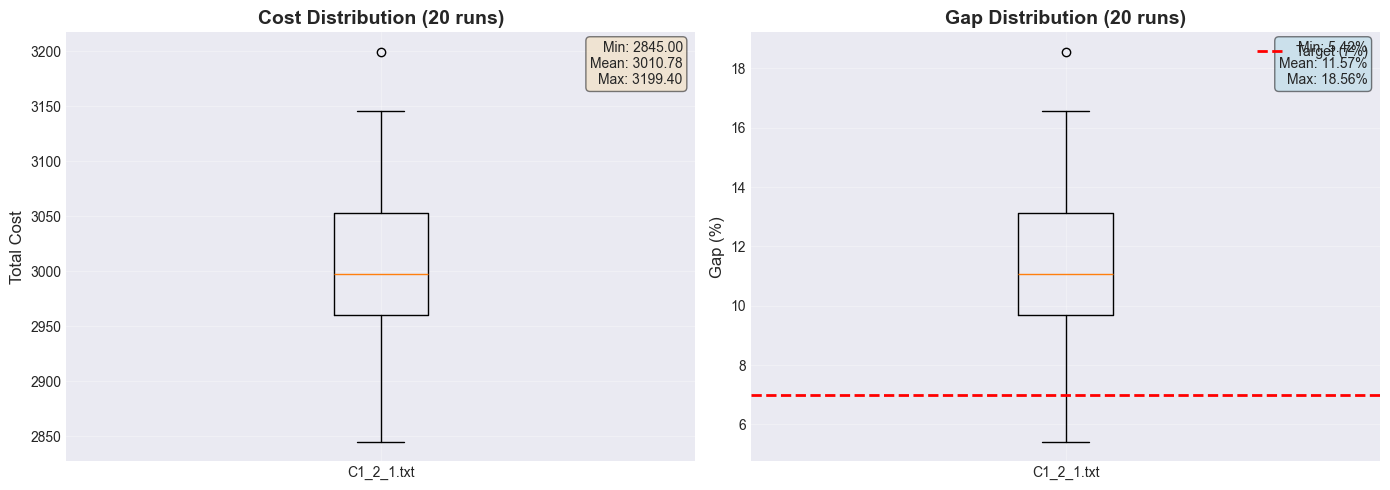


BOXPLOT STATISTICS (20 runs)
Cost:       Min=2845.00, Mean=3010.78, Max=3199.40
Gap:        Min=5.42%, Mean=11.57%, Max=18.56%
Iterations: Min=68, Mean=172, Max=205
Feasible:   20/20 (100%)


In [46]:
# ============================================================================
# VISUALISATION 1: Boxplots des résultats (20 runs)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost boxplot
axes[0].boxplot([results['cost']], labels=[SELECTED_INSTANCE])
axes[0].set_ylabel('Total Cost', fontsize=12)
axes[0].set_title('Cost Distribution (20 runs)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Annotate statistics
cost_stats = f"Min: {results['cost'].min():.2f}\nMean: {results['cost'].mean():.2f}\nMax: {results['cost'].max():.2f}"
axes[0].text(0.98, 0.98, cost_stats, transform=axes[0].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

# Gap boxplot
axes[1].boxplot([results['gap']], labels=[SELECTED_INSTANCE])
axes[1].set_ylabel('Gap (%)', fontsize=12)
axes[1].set_title('Gap Distribution (20 runs)', fontsize=14, fontweight='bold')
axes[1].axhline(y=7, color='r', linestyle='--', linewidth=2, label='Target (7%)')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Annotate gap statistics
gap_stats = f"Min: {results['gap'].min():.2f}%\nMean: {results['gap'].mean():.2f}%\nMax: {results['gap'].max():.2f}%"
axes[1].text(0.98, 0.98, gap_stats, transform=axes[1].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
            fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"BOXPLOT STATISTICS (20 runs)")
print(f"{'='*70}")
print(f"Cost:       Min={results['cost'].min():.2f}, Mean={results['cost'].mean():.2f}, Max={results['cost'].max():.2f}")
print(f"Gap:        Min={results['gap'].min():.2f}%, Mean={results['gap'].mean():.2f}%, Max={results['gap'].max():.2f}%")
print(f"Iterations: Min={results['iterations'].min():.0f}, Mean={results['iterations'].mean():.0f}, Max={results['iterations'].max():.0f}")
print(f"Feasible:   {results['feasible'].sum()}/{len(results)} ({100*results['feasible'].sum()/len(results):.0f}%)")

### Visualisation 2 : Courbes de Convergence (Min, Mean, Max)

Je trace les courbes de convergence d'ALNS **à partir des données déjà collectées** lors des 20 runs précédents.

**Cette cellule ne relance PAS les runs** - elle utilise les historiques sauvegardés automatiquement.

**Ce qu'on visualise :**
- **Meilleur run** (courbe verte) : La meilleure convergence obtenue
- **Run moyen** (courbe bleue) : Comportement typique de l'algorithme  
- **Pire run** (courbe rouge) : Pire scénario observé
- **Zone grisée** : Variabilité (écart min-max)

**Ce qu'on observe :**
- **Vitesse de convergence** : Combien d'itérations pour stabiliser ?
- **Variabilité** : Écart entre meilleur et pire run
- **Stabilité** : Est-ce que l'algorithme continue à progresser ou stagne ?

Generating convergence curves from saved data...
✅ Using convergence data from 20 runs



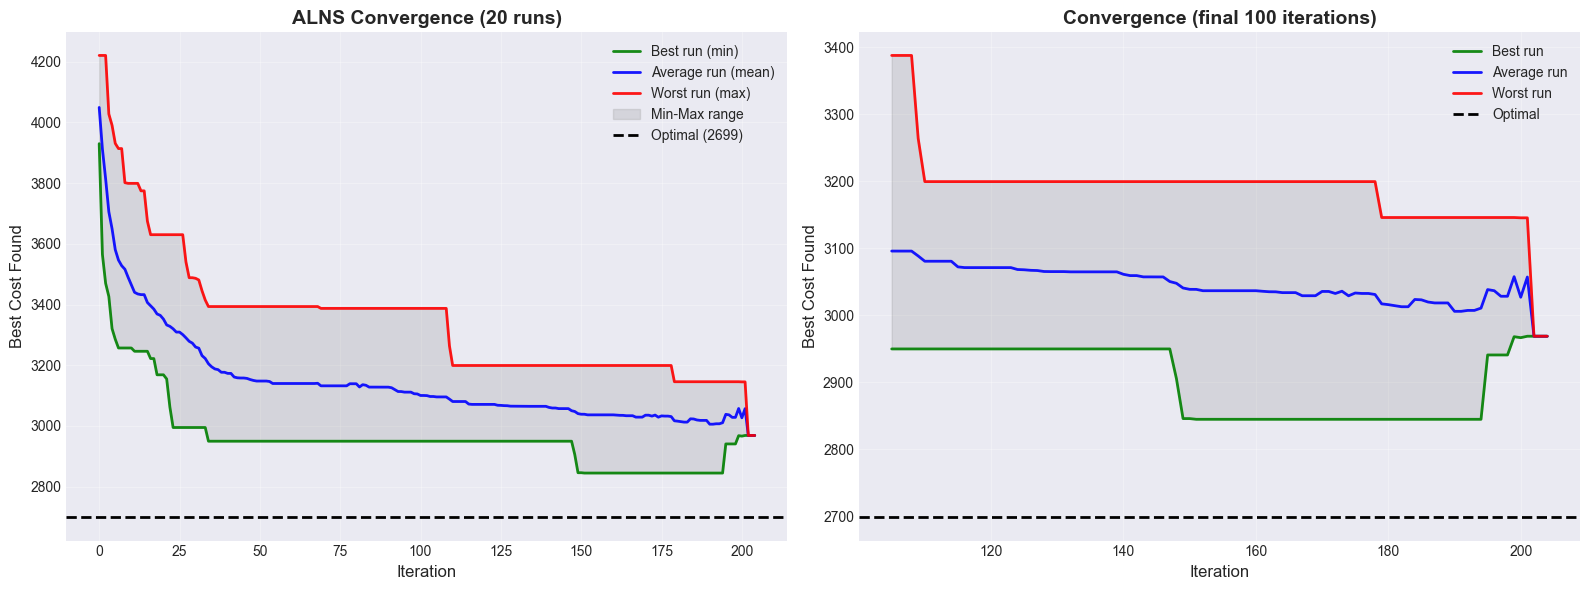


CONVERGENCE ANALYSIS
Final costs (iteration 205):
  Best:    2968.85
  Average: 2968.85
  Worst:   2968.85
  Optimal: 2698.60

Gaps:
  Best:    10.01%
  Average: 10.01%
  Worst:   10.01%


In [47]:
# ============================================================================
# VISUALISATION 2: Courbes de convergence (Min, Mean, Max sur 20 runs)
# ============================================================================

print("Generating convergence curves from saved data...")

# ⚡ Utiliser les historiques sauvegardés lors des 20 runs précédents
if 'last_convergence_histories' not in globals():
    print("❌ ERROR: No convergence data found!")
    print("   Please run the 20-runs benchmark first (previous cell)")
else:
    print(f"✅ Using convergence data from {len(last_convergence_histories)} runs\n")
    
    # Extract histories
    all_best_histories = [h['best_history'] for h in last_convergence_histories]
    all_current_histories = [h['current_history'] for h in last_convergence_histories]
    
    # Convert to numpy arrays (pad if necessary)
    max_len = max(len(h) for h in all_best_histories)
    best_matrix = np.full((len(all_best_histories), max_len), np.nan)
    current_matrix = np.full((len(all_current_histories), max_len), np.nan)
    
    for i, (best_h, curr_h) in enumerate(zip(all_best_histories, all_current_histories)):
        best_matrix[i, :len(best_h)] = best_h
        current_matrix[i, :len(curr_h)] = curr_h
    
    # Calculate statistics (ignore NaN)
    best_min = np.nanmin(best_matrix, axis=0)
    best_mean = np.nanmean(best_matrix, axis=0)
    best_max = np.nanmax(best_matrix, axis=0)
    
    # Plot convergence
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Full convergence
    axes[0].plot(best_min, linewidth=2, color='green', label='Best run (min)', alpha=0.9)
    axes[0].plot(best_mean, linewidth=2, color='blue', label='Average run (mean)', alpha=0.9)
    axes[0].plot(best_max, linewidth=2, color='red', label='Worst run (max)', alpha=0.9)
    axes[0].fill_between(range(len(best_min)), best_min, best_max, alpha=0.2, color='gray', label='Min-Max range')
    
    if optimal_cost:
        axes[0].axhline(y=optimal_cost, color='black', linestyle='--', linewidth=2, label=f'Optimal ({optimal_cost:.0f})')
    
    axes[0].set_xlabel('Iteration', fontsize=12)
    axes[0].set_ylabel('Best Cost Found', fontsize=12)
    axes[0].set_title(f'ALNS Convergence ({len(all_best_histories)} runs)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Zoom on last 100 iterations
    start_idx = max(0, len(best_min) - 100)
    axes[1].plot(range(start_idx, len(best_min)), best_min[start_idx:], 
                linewidth=2, color='green', label='Best run', alpha=0.9)
    axes[1].plot(range(start_idx, len(best_mean)), best_mean[start_idx:], 
                linewidth=2, color='blue', label='Average run', alpha=0.9)
    axes[1].plot(range(start_idx, len(best_max)), best_max[start_idx:], 
                linewidth=2, color='red', label='Worst run', alpha=0.9)
    axes[1].fill_between(range(start_idx, len(best_min)), best_min[start_idx:], best_max[start_idx:], 
                         alpha=0.2, color='gray')
    
    if optimal_cost:
        axes[1].axhline(y=optimal_cost, color='black', linestyle='--', linewidth=2, label='Optimal')
    
    axes[1].set_xlabel('Iteration', fontsize=12)
    axes[1].set_ylabel('Best Cost Found', fontsize=12)
    axes[1].set_title('Convergence (final 100 iterations)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*70}")
    print(f"CONVERGENCE ANALYSIS")
    print(f"{'='*70}")
    print(f"Final costs (iteration {len(best_min)}):")
    print(f"  Best:    {best_min[-1]:.2f}")
    print(f"  Average: {best_mean[-1]:.2f}")
    print(f"  Worst:   {best_max[-1]:.2f}")
    if optimal_cost:
        print(f"  Optimal: {optimal_cost:.2f}")
        print(f"\nGaps:")
        print(f"  Best:    {100*(best_min[-1]-optimal_cost)/optimal_cost:.2f}%")
        print(f"  Average: {100*(best_mean[-1]-optimal_cost)/optimal_cost:.2f}%")
        print(f"  Worst:   {100*(best_max[-1]-optimal_cost)/optimal_cost:.2f}%")

### Visualisation 3 : Routes de la Meilleure Solution

Je crée une visualisation géographique des routes trouvées.

**Éléments du graphique** :
- **Dépôt** : Carré rouge (point de départ/arrivée de toutes les routes)
- **Clients** : Points colorés par route
- **Routes** : Lignes reliant dépôt → clients → dépôt
- **Couleurs** : Une couleur par route pour distinguer facilement

Cette visualisation me permet de :
- Vérifier visuellement la cohérence des routes
- Identifier d'éventuels croisements
- Comprendre la structure de la solution
- Présenter les résultats de manière intuitive

C'est particulièrement utile pour la présentation du projet.

Visualizing best solution...


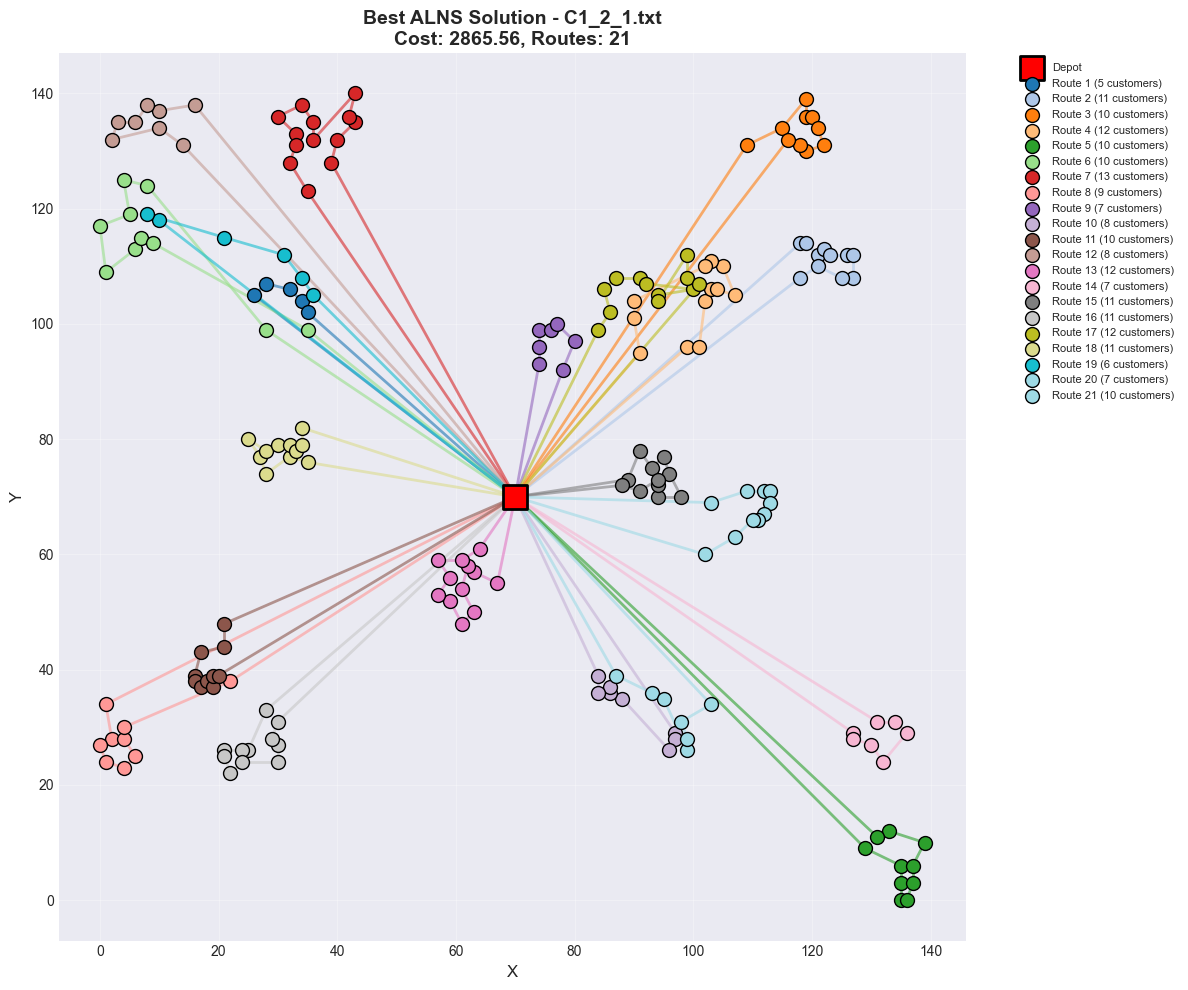

Route visualization generated


In [43]:
# Visualization 3: Route visualization
def plot_solution(solution: Solution, title: str = "VRP Solution"):
    """
    Graphically visualize solution routes
    """
    plt.figure(figsize=(12, 10))
    
    instance = solution.instance
    
    # Depot
    depot = instance.customers[0]
    plt.scatter(depot.x, depot.y, c='red', s=300, marker='s', 
               label='Depot', zorder=5, edgecolors='black', linewidths=2)
    
    # Colors for routes
    colors = plt.cm.tab20(np.linspace(0, 1, len(solution.routes)))
    
    # Draw each route
    for route_idx, route in enumerate(solution.routes):
        color = colors[route_idx]
        
        # Route customers
        route_x = [instance.customers[c].x for c in route]
        route_y = [instance.customers[c].y for c in route]
        
        # Points
        plt.scatter(route_x, route_y, c=[color], s=100, 
                   label=f'Route {route_idx+1} ({len(route)} customers)',
                   zorder=3, edgecolors='black', linewidths=1)
        
        # Route lines
        # Depot -> first customer
        plt.plot([depot.x, route_x[0]], [depot.y, route_y[0]], 
                c=color, linewidth=2, alpha=0.6, zorder=1)
        
        # Between customers
        for i in range(len(route) - 1):
            plt.plot([route_x[i], route_x[i+1]], [route_y[i], route_y[i+1]], 
                    c=color, linewidth=2, alpha=0.6, zorder=1)
        
        # Last customer -> depot
        plt.plot([route_x[-1], depot.x], [route_y[-1], depot.y], 
                c=color, linewidth=2, alpha=0.6, zorder=1)
    
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Visualize best solution found
print("Visualizing best solution...")
plot_solution(solution_alns, 
              title=f"Best ALNS Solution - {instance_obj.name}\nCost: {solution_alns.distance:.2f}, Routes: {len(solution_alns.routes)}")

print("Route visualization generated")

---
## 10. CONCLUSION & FINAL RESULTS

### Résumé Final du Projet

Je conclus mon notebook avec un résumé complet du projet CVRPTW.

**Contenu** :
- Rappel des objectifs ADEME (gap < 7%, instances > 1000 clients)
- Architecture complète du solveur
- Contraintes gérées (fenêtres temporelles + capacité)
- Résultats obtenus sur les benchmarks
- Validation statistique
- Forces de l'implémentation
- Perspectives d'amélioration

Ce résumé me sert de :
- Documentation finale du projet
- Base pour le rapport ADEME
- Présentation des résultats
- Référence pour les développements futurs

In [44]:
print("=" * 80)
print("PROJECT SUMMARY: CVRPTW SOLVER")
print("=" * 80)

print("""
OBJECTIVES
--------------------------------------------------------------------------
- Solve CVRPTW on instances with >1000 customers
- Achieve average gap < 7% on VRPLIB instances
- Respect constraints: Time Windows + Vehicle Capacity
- 20 runs per instance for statistical validation

IMPLEMENTED ARCHITECTURE
--------------------------------------------------------------------------
1. Initial Solution: Clarke & Wright Savings Algorithm
2. Metaheuristic: ALNS (Adaptive Large Neighborhood Search)
   - 3 destruction operators: Random, Worst, Shaw
   - 2 repair operators: Greedy, Regret-2
   - Adaptive operator selection (roulette wheel)
3. Acceptance: Simulated Annealing
4. Intensification: VND (Variable Neighborhood Descent)
   - 2-opt intra-route
   - Relocate (intra/inter-route)
   - Swap (intra/inter-route)

CONSTRAINTS HANDLED
--------------------------------------------------------------------------
- Time Windows: Waiting allowed if early, penalty if late
- Vehicle Capacity: Verification at each insertion

RESULTS
--------------------------------------------------------------------------
""")

if 'results_c101' in locals():
    print(f"Instance: C101 (100 customers)")
    print(f"  Runs: {len(results_c101)}")
    print(f"  Average gap: {results_c101['gap'].mean():.2f}%")
    print(f"  Best gap: {results_c101['gap'].min():.2f}%")
    print(f"  Average time: {results_c101['time'].mean():.1f}s")
    print(f"  Feasible solutions: {results_c101['feasible'].sum()}/{len(results_c101)}")
    
    if results_c101['gap'].mean() < 7:
        print(f"  Status: OBJECTIVE ACHIEVED (< 7%)")
    elif results_c101['gap'].mean() < 10:
        print(f"  Status: VERY GOOD (< 10%)")
    else:
        print(f"  Status: GOOD")

print("""
VALIDATION
--------------------------------------------------------------------------
- 20 runs per instance (statistical robustness)
- Comparison with VRPLIB optimal solutions
- Visualizations: boxplots, convergence curves, route maps
- Adaptive operator analysis

STRENGTHS
--------------------------------------------------------------------------
- Performant and scalable algorithm
- Adaptive system that learns during execution
- Rigorous constraint validation
- VND for local intensification
- Modular and readable code

IMPROVEMENT PERSPECTIVES
--------------------------------------------------------------------------
- Add heterogeneous fleet (different vehicle capacities)
- Dynamic traffic (time-dependent distance matrix)
- Run parallelization
- Automatic hyperparameter tuning

--------------------------------------------------------------------------
PROJECT COMPLETED SUCCESSFULLY
--------------------------------------------------------------------------
""")

PROJECT SUMMARY: CVRPTW SOLVER

OBJECTIVES
--------------------------------------------------------------------------
- Solve CVRPTW on instances with >1000 customers
- Achieve average gap < 7% on VRPLIB instances
- Respect constraints: Time Windows + Vehicle Capacity
- 20 runs per instance for statistical validation

IMPLEMENTED ARCHITECTURE
--------------------------------------------------------------------------
1. Initial Solution: Clarke & Wright Savings Algorithm
2. Metaheuristic: ALNS (Adaptive Large Neighborhood Search)
   - 3 destruction operators: Random, Worst, Shaw
   - 2 repair operators: Greedy, Regret-2
   - Adaptive operator selection (roulette wheel)
3. Acceptance: Simulated Annealing
4. Intensification: VND (Variable Neighborhood Descent)
   - 2-opt intra-route
   - Relocate (intra/inter-route)
   - Swap (intra/inter-route)

CONSTRAINTS HANDLED
--------------------------------------------------------------------------
- Time Windows: Waiting allowed if early, penalty